In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm
from pymc.Matplot import plot as pmplot


sns.set()


In [107]:
dick = pd.read_pickle('country_data.pkl')

### 2020-04-14
# Germany has a negative dead_inc 2020-04-11, which makes poisson obs fail. 
# patching that number here

ger = dick['Germany']
ger.at['2020-04-11','dead_inc'] = 0
dick['Germany'] = ger

In [108]:


def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

def process_country(country_name):
    
    country = dick[country_name]
    country_population = country_populations.loc[country_name,'population']
    country['conf_per_M'] = country['confirmed'] / (country_population / 1e6)
    country['dead_per_M'] = country['deceased'] / (country_population / 1e6)
    
    return country



In [109]:
r_prior = pm.rlognormal(0.27,1/0.05**2,100000)
f_prior = pm.rbeta(5,200,100000)

In [110]:
### ASSUMPTIONS ###
### 1) nr of dead inc is a function of nr of confirmed
### D = mortality rate (f) x confirmed total (C) x growth rate for confirmed (r)
### 2) D = f * C
### 3) D = C * r * f 

def inference(df,C,D,country_name):
    
    f_alpha = pm.Uniform('f_alpha',1,100)
    f_beta = pm.Uniform ('f_beta',50,500)
    
    #r_mu = pm.Uniform('r_mu',0.2,0.6) #high autocorrelation for Italy
    r_mu = pm.Uniform('r_mu',0.05,0.6)

    r_sigma = pm.Uniform('r_sigma',0,0.2)
    
    r = pm.Lognormal('r',r_mu, 1 / r_sigma ** 2)
    
    #r = pm.Lognormal('r',0.27,1/0.05**2)
    
    f = pm.Beta('f',f_alpha,f_beta)
    #m = pm.Uniform ('m',-2,2)

    @pm.deterministic()
    def prediction(C=C,r=r,f=f):
        return C * r * f 

    obs = pm.Poisson('obs',prediction, observed=True,value=D)

    model = pm.Model([f,r,prediction,obs])
    try:
        map_ = pm.MAP(model)
        map_.fit()
        
    except:
        print ('cant fit {}'.format(country_name))

    mcmc = pm.MCMC(model)

    mcmc.sample(200000,60000,4)
    
    r_mu_post = mcmc.trace('r_mu')[:]
    r_sigma_post = mcmc.trace('r_sigma')[:]
    r_post = mcmc.trace('r')[:]
    f_post = mcmc.trace('f')[:]
    f_alpha_post = mcmc.trace('f_alpha')[:]
    f_beta_post = mcmc.trace('f_beta')[:]
    
    
    pmplot(r_mu_post,'r_mu_post')
    pmplot(r_sigma_post,'r_sigma_post')
    pmplot(f_alpha_post,'f_alpha_post')
    pmplot(f_beta_post,'f_beta_post')
    pmplot(r_post,'r_post')
    pmplot(f_post,'f_post')

    prediction_post = mcmc.trace('prediction')[:,0]

    result = pd.DataFrame({'r_post':r_post,
                          'f_post':f_post,
                          'prediction_post':prediction_post})

    print ()
    print ('++++++++++++++ {} ++++++++++++++++'.format(country_name))
    print (result.describe())
    print()
    
    plt.figure(figsize=(18,12))
    plt.hist(r_prior,color='r',label='r prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.r_post,color='g',label='r posterior',alpha=0.7,histtype='stepfilled',density=True)
    plt.legend(loc='upper left')

    plt.figure(figsize=(18,12))
    plt.hist(f_prior,color='r',label='f prior',alpha=0.5,histtype='stepfilled',density=True)
    plt.hist(result.f_post,color='g',label='f posterior',alpha=0.7,histtype='stepfilled',density=True)
    
    plt.legend(loc='upper left')
    
    return result



In [111]:

def create_posterior_samples(result):
    N = 10000
    f_samples = np.random.choice(result.f_post,replace=True,size=N)
    r_samples = np.random.choice(result.r_post,replace=True,size=N)

    samples = np.array([pm.rpoisson(C[i] * r_samples * f_samples,N) for i in range(len(C))])

    samples.shape

    sample_df = pd.DataFrame(samples,index=range(len(samples)))
    sample_df.index.name='day'
    sample_df.columns.name='sample_nr'
    return sample_df

In [112]:

def plot(result,df,sample_df,country_name):
    
    samples_89 = np.percentile(sample_df.iloc[-1,:],[5.5,94.5])
    
    plt.figure(figsize=(18,12))
    title_postfix = r' Sample posterior mean growth factor $\mu$: {:.2f} posterior mean mortality rate $\mu$: {:.4f}'.format(
    result.r_post.mean(),result.f_post.mean())
    
    title_postfix_2 = ' Last Day Sample 89% CI: {:.2f} , {:.2f} : Last Day Actual: {}'.format(
        samples_89[0],samples_89[1],df.iloc[-1,5])

    sns.violinplot(data=sample_df.T,inner='quartile',scale='count',palette=['orange'])

    plt.title('Bayesian Posterior Expected number of deaths per day {}, after the day CONFIRMED hit {} \n'.format(
        country_name,limit) + title_postfix + '\n' + title_postfix_2)

    plt.ylabel('Expected number of deaths per day')
    plt.xlabel('Day after number of confirmed hit {}'.format(limit))
    plt.scatter(range(len(df)),df['dead_inc'],color='crimson',label='actual data')
    plt.legend(loc='upper left')
    
    plt.savefig('{}_violinplot.jpg'.format(country_name),format='jpg')


++++++++++++++++++++++ India +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-10       7598  1.129814   873.0       246     1.088496      20.0   
2020-04-11       8446  1.111608   848.0       288     1.170732      42.0   
2020-04-12       9205  1.089865   759.0       331     1.149306      43.0   
2020-04-13      10453  1.135578  1248.0       358     1.081571      27.0   
2020-04-14      11487  1.098919  1034.0       393     1.097765      35.0   

            pct_dead  conf_over_dead  dead_conf_ratio  conf_per_M  dead_per_M  
2020-04-10  3.237694       30.886179         0.963429    5.505780    0.178260  
2020-04-11  3.409898       29.326389         1.053187    6.120270    0.208695  
2020-04-12  3.595872       27.809668         1.054539    6.670269    0.239854  
2020-04-13  3.424854       29.198324         0.952441    7.574614    0.259419  
2020-04-14  3.421259       29.229008         0.998950    8.323887    0.284782  
 [-------


++++++++++++++++++++++ Spain +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-10     158273  1.032965  5051.0     16081     1.041044     634.0   
2020-04-11     163027  1.030037  4754.0     16606     1.032647     525.0   
2020-04-12     166831  1.023334  3804.0     17209     1.036312     603.0   
2020-04-13     170099  1.019589  3268.0     17756     1.031786     547.0   
2020-04-14     172541  1.014356  2442.0     18056     1.016896     300.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-10  10.160293        9.842236         1.007821  3385.172741   
2020-04-11  10.186043        9.817355         1.002534  3486.852189   
2020-04-12  10.315229        9.694404         1.012683  3568.212857   
2020-04-13  10.438627        9.579804         1.011963  3638.109457   
2020-04-14  10.464759        9.555882         1.002503  3690.339413   

            dead_per_M  
2020-04-10  343.943458  
2020-04-11  

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Spain ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.257143      0.005420         7.054048
std        0.238046      0.001036         0.052517
min        0.750210      0.003292         6.860447
25%        1.089668      0.004660         7.018194
50%        1.231247      0.005339         7.054256
75%        1.411329      0.006033         7.089544
max        1.996750      0.008710         7.278697



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


sample_df.head()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0            10     9     3     6     4     9     8     4     2     5  ...   
1            14    15     6    20    11     7    15     7     8     7  ...   
2            24    25    11    12    17     9    19    15    10     5  ...   
3            18    10     7    19    11     6    12    22    10     3  ...   
4            39    46    21    26    23    31    44    32    25    18  ...   
5            67    57    22    41    25    29    78    36    37    24  ...   
6            84    61    32    48    59    34    72    47    29    40  ...   
7            74    67    40    86    61    47   103    55    39    43  ...   
8           100    94    35    78    79    66   108    87    48    43  ...   
9           118   101    55    86    87    61   142   105    80    56  ...   
10          153   174    70   111   119    90  

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Sweden ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.355378      0.005104         6.811950
std        0.267708      0.000986         0.210408
min        0.689155      0.002447         5.963527
25%        1.150772      0.004364         6.669819
50%        1.316470      0.005060         6.809952
75%        1.523620      0.005787         6.952098
max        2.766546      0.010044         7.820599



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


sample_df.head()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0             7     4     6     8     4     5     5     6    10    14  ...   
1             7     7     6     8     7    11    15    12     5     8  ...   
2             6    12     7     8     4     5    12    11     7    13  ...   
3             7    10     5    15     8    12     9     8     9    10  ...   
4            13     2    11     9    11    10    11     9     7     8  ...   
5            11    14    15    11     6    11    16    17     7    19  ...   
6            22    13     9    18     9    15    13    14    16    23  ...   
7             9    15    13    18    20    18    12    15    14    17  ...   
8            14    11    12    17    10    18    18    10    12    16  ...   
9            15    21    18    14     8    24    18    23    15    29  ...   
10           19    11    23    29     9    18  

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ US ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.341388      0.002896         4.803294
std        0.244774      0.000569         0.029777
min        0.720498      0.001840         4.686649
25%        1.165474      0.002464         4.783271
50%        1.325122      0.002832         4.803317
75%        1.522295      0.003218         4.823297
max        2.042676      0.005204         4.914948



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


sample_df.head()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0             5     5     2     3     2     2     5     8     0     5  ...   
1             5     5    10     6     9     5     8     6     0     8  ...   
2             4    19     8    12     7     6     8    12     5     2  ...   
3             4    19    12    10     7     8    20    10    10     4  ...   
4             9    16    10    25     8    10    19    12    10     9  ...   
5            11    21    16    18    18    17    24    18    18    12  ...   
6            10    45    15    28    21    12    33    18    19    17  ...   
7            19    39    15    43    21    21    41    35    34    19  ...   
8            35    74    50    71    58    40    81    47    46    47  ...   
9            38   109    71    87    77    51    99    69    67    61  ...   
10           65   127   103   123   105    72  

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Korea, South ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.343224      0.000415         0.676257
std        0.262860      0.000086         0.046301
min        0.612436      0.000188         0.497751
25%        1.145512      0.000350         0.644521
50%        1.309366      0.000407         0.675183
75%        1.518364      0.000469         0.706678
max        2.997975      0.000916         0.903026



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df.head()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0             1     2     0     0     4     1     2     2     1     0  ...   
1             0     0     2     1     0     2     1     1     1     0  ...   
2             0     0     0     1     2     0     1     0     0     0  ...   
3             2     5     1     1     3     0     2     0     0     5  ...   
4             1     4     6     2     1     1     6     2     3     4  ...   
5             2     2     9     0     6     4     2     2     3     6  ...   
6             2     6    13     4     6     0     3     0     4     5  ...   
7             1     8    10     3     5     2     5     5     1     4  ...   
8             4     3     4     0     9     3     1     1     2     2  ...   
9             0     7     9     6     7     4     2     2     3     6  ...   
10            4     6     7     5    10     4  

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



++++++++++++++++++++++ Netherlands +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-10      23249  1.061453  1346.0      2520     1.048689     117.0   
2020-04-11      24571  1.056863  1322.0      2653     1.052778     133.0   
2020-04-12      25746  1.047821  1175.0      2747     1.035432      94.0   
2020-04-13      26710  1.037443   964.0      2833     1.031307      86.0   
2020-04-14      27580  1.032572   870.0      2955     1.043064     122.0   

             pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-04-10  10.839176        9.225794         0.987975  1356.823675   
2020-04-11  10.797281        9.261591         0.996135  1433.976279   
2020-04-12  10.669619        9.372406         0.988176  1502.549888   
2020-04-13  10.606514        9.428168         0.994086  1558.809427   
2020-04-14  10.714286        9.333333         1.010161  1609.583077   

            dead_per_M  
2020-04-10  147.068505  
2020-0

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Netherlands ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.375811      0.005764         8.684084
std        0.279512      0.001115         0.160461
min        0.745795      0.002584         8.080684
25%        1.161951      0.004910         8.575946
50%        1.340346      0.005688         8.682855
75%        1.552386      0.006567         8.790378
max        2.891469      0.010059         9.346954

sample_df.head()


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0            17    10    16     7     8     9     6     6     9     9  ...   
1            29     7    14     9    15    11    13    12    17    10  ...   
2            19    10    12     9    18    14    18    12    16    18  ...   
3            49    18    17    17    21    13    18    12    14    17  ...   
4            37    28    20    16    23    17    22    23    15    19  ...   
5            41    25    21    21    32    24    16    17    25    21  ...   
6            57    34    27    17    47    19    25    25    34    28  ...   
7            61    29    34    26    42    24    28    29    34    31  ...   
8            83    55    32    34    32    34    36    26    37    42  ...   
9            80    44    40    38    54    32    45    44    48    37  ...   
10          101    57    62    34    54    42    52    41    57 

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Canada ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.340261      0.002259         3.706463
std        0.278023      0.000473         0.124161
min        0.613477      0.001035         3.240313
25%        1.128672      0.001895         3.621957
50%        1.299326      0.002233         3.704719
75%        1.528878      0.002570         3.790212
max        2.767589      0.004687         4.301119



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sample_df.head()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0             3     2     5     5     5     1     2     4     6     4  ...   
1             5     2     6     0     8     7     4     3     6     4  ...   
2             9     3    14     7    10     3     5     6     5     7  ...   
3            17     2     6     5    14     5     5    10     4     4  ...   
4            24    10    10    11    17    12     8     8    13    11  ...   
5            11     9    18    13    18     9    16    15    12    16  ...   
6            21     4    23    14    26    10    14    16    17    10  ...   
7            20    12    25    14    19    11    16    20    14    26  ...   
8            22    13    23    11    29    15    25    21    28    24  ...   
9            22    11    36    27    33    16    31    26    14    22  ...   
10           43    27    32    22    35    17  

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



++++++++++++++++++++++ Germany +++++++++++++++++++++++
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-04-10     122171  1.033762  3990.0      2767     1.061373     160.0   
2020-04-11     124908  1.022403  2737.0      2736     0.988797       0.0   
2020-04-12     127854  1.023585  2946.0      3022     1.104532     286.0   
2020-04-13     130072  1.017348  2218.0      3194     1.056916     172.0   
2020-04-14     131359  1.009895  1287.0      3294     1.031309     100.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  dead_per_M  
2020-04-10  2.264858       44.152873         1.026710  1458.167246   33.025422  
2020-04-11  2.190412       45.653509         0.967130  1490.834604   32.655422  
2020-04-12  2.363634       42.307743         1.079082  1525.996473   36.068964  
2020-04-13  2.455563       40.723857         1.038893  1552.469326   38.121863  
2020-04-14  2.507632       39.878264         1.021204  1567.830265   39.315410  
 

/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_sigma_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_alpha_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_beta_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting r_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))


Plotting f_post


/usr/lib/python3.6/site-packages/pymc/Matplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize=(10, 6))



++++++++++++++ Germany ++++++++++++++++
             r_post        f_post  prediction_post
count  35000.000000  35000.000000     35000.000000
mean       1.361027      0.001208         1.635848
std        0.286404      0.000256         0.028338
min        0.669412      0.000659         1.512377
25%        1.130868      0.001006         1.616699
50%        1.328253      0.001184         1.635835
75%        1.563406      0.001391         1.654764
max        2.438353      0.002348         1.752358

sample_df.head()
sample_nr  0     1     2     3     4     5     6     7     8     9     ...  \
day                                                                    ...   
0             1     3     2     3     2     5     2     0     3     1  ...   
1             1     1     0     4     1     3     1     2     2     0  ...   
2             1     5     2     4     4     5     1     3     3     1  ...   
3             0     5     1     4     3     4     5     1     3     6  ...   
4             

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


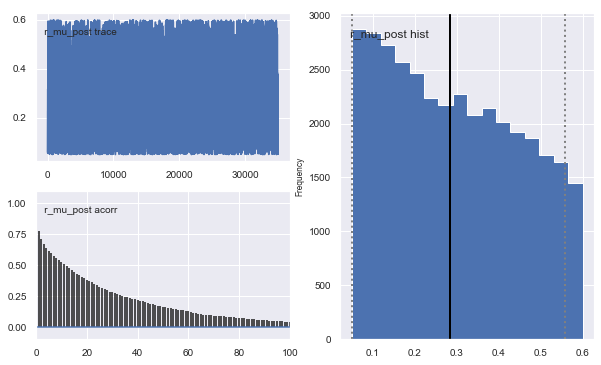

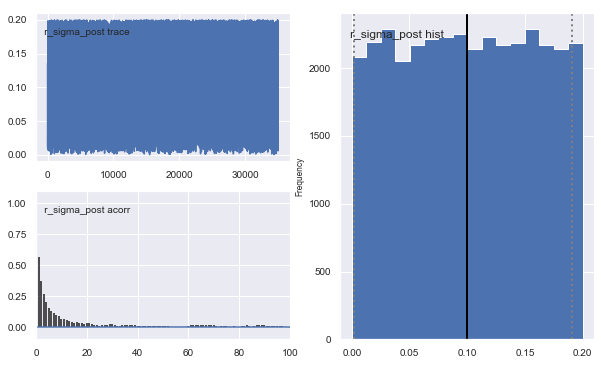

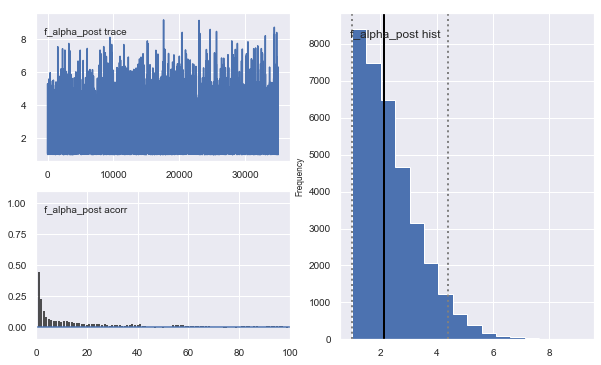

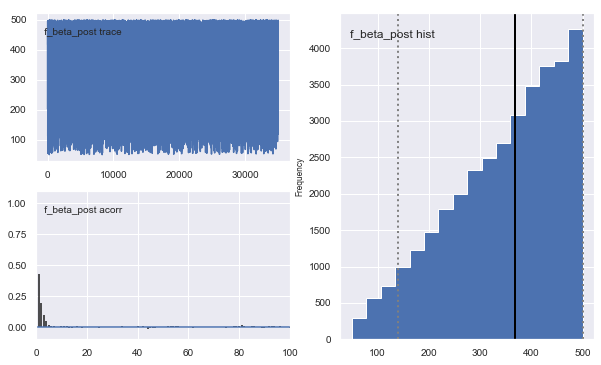

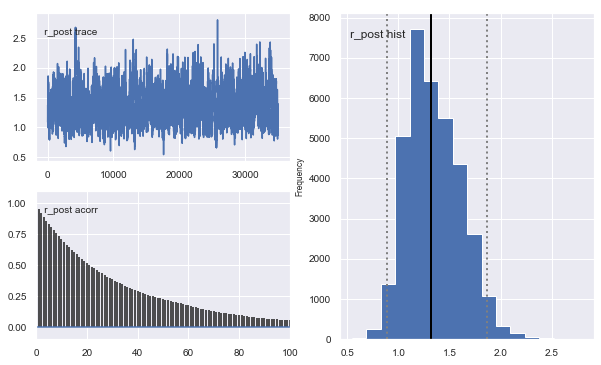

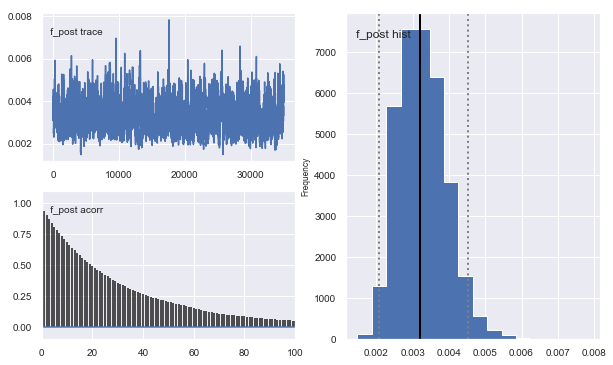

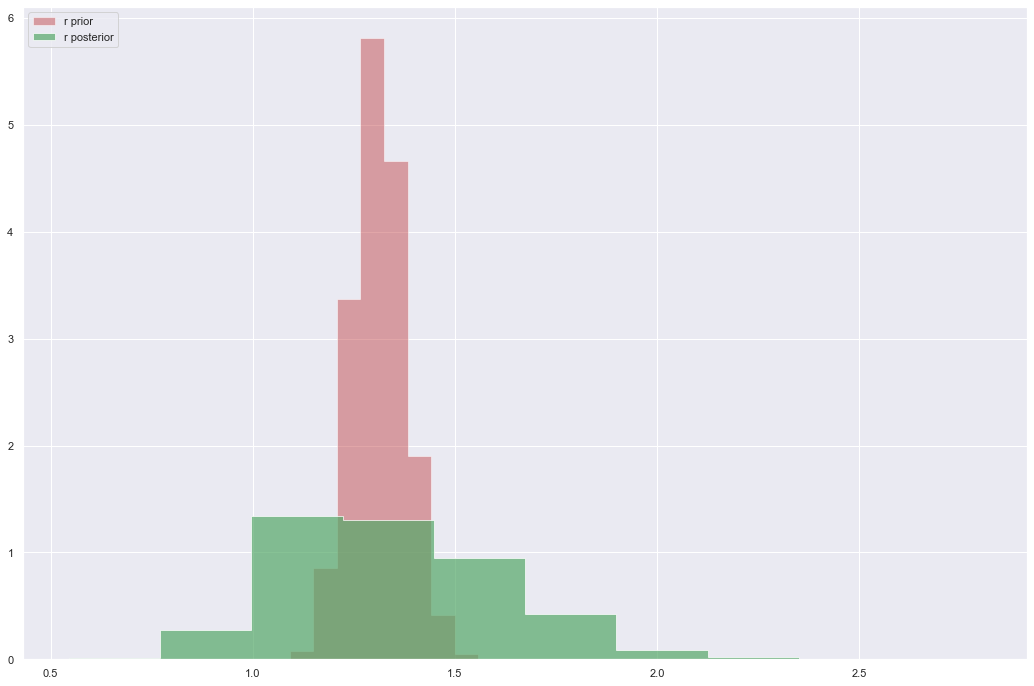

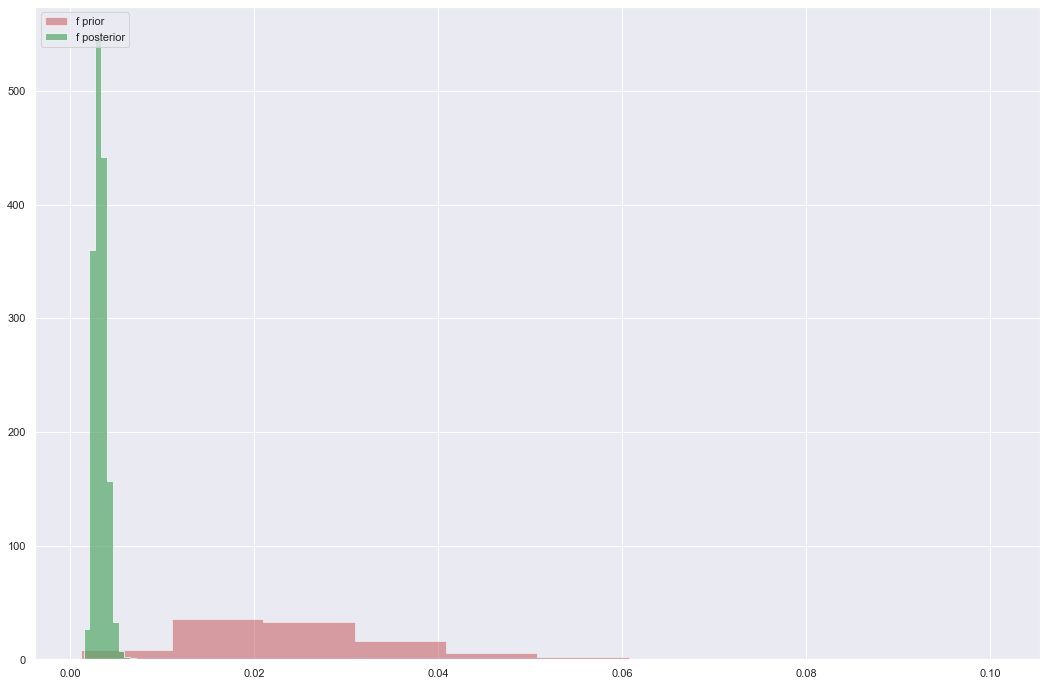

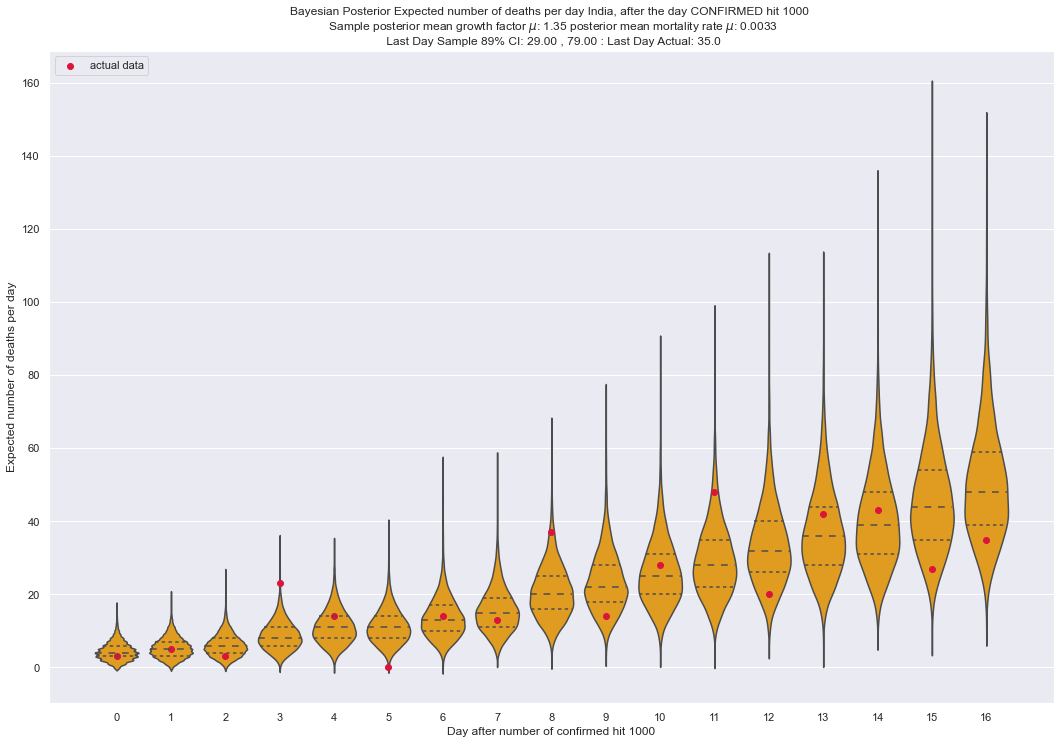

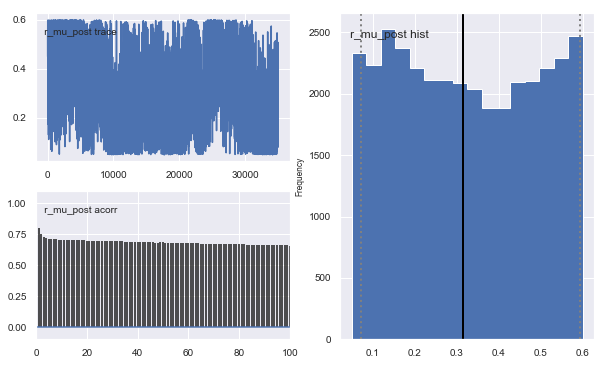

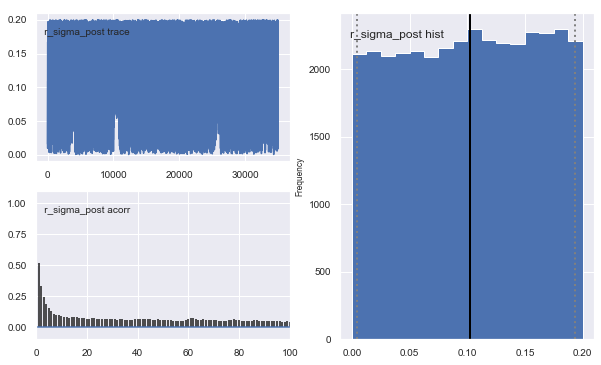

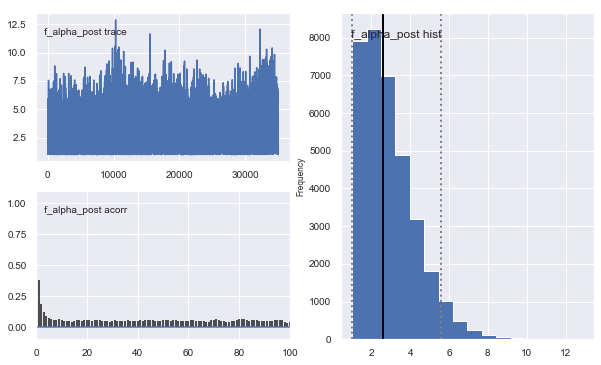

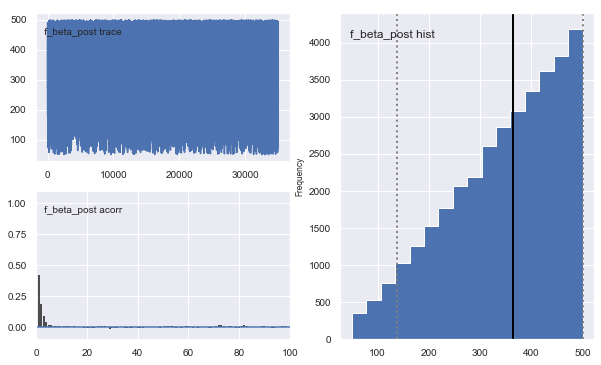

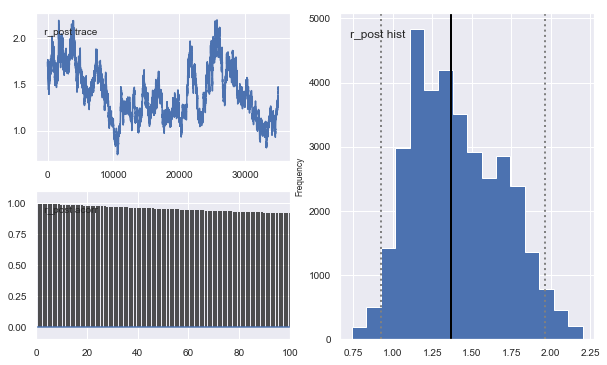

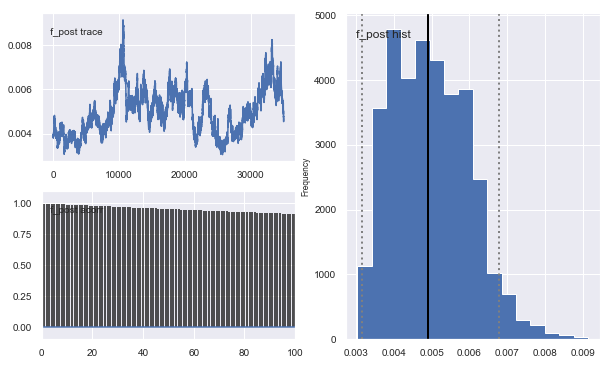

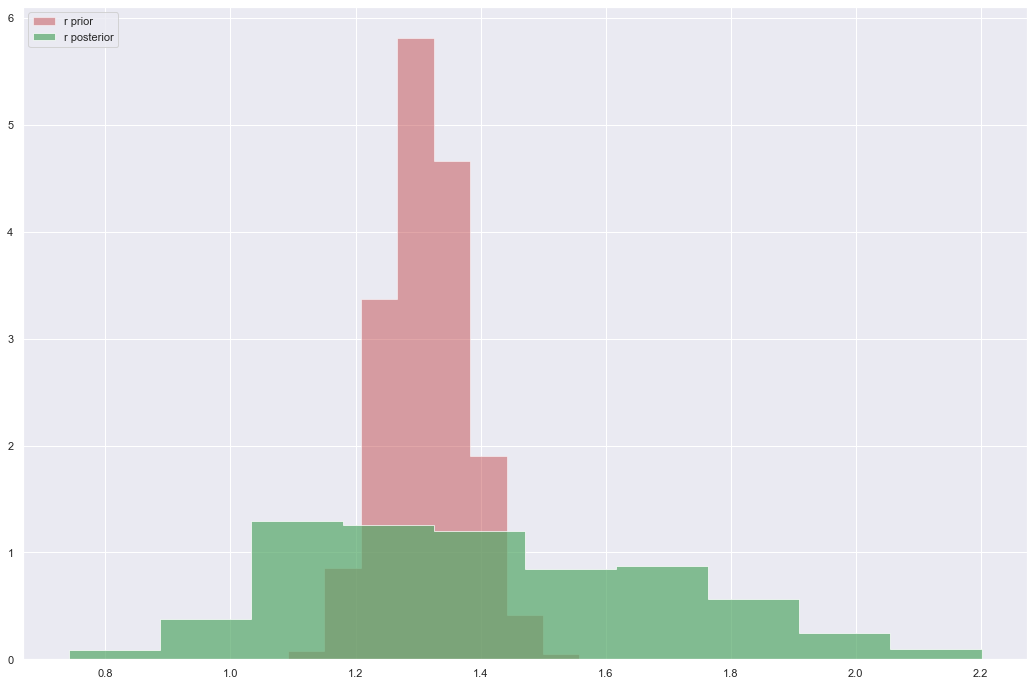

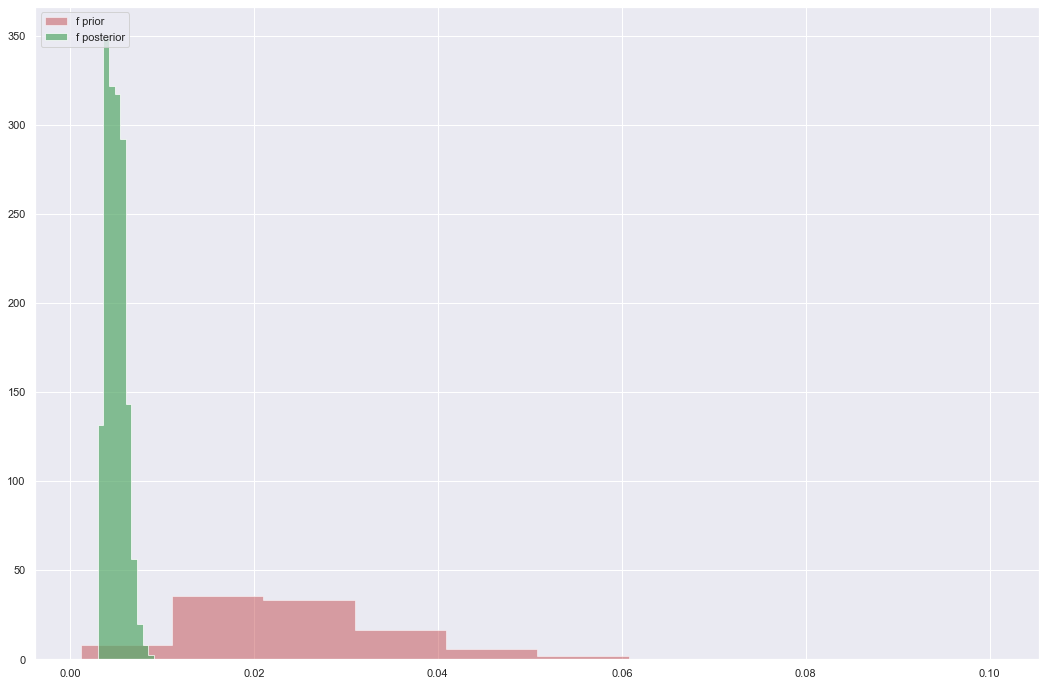

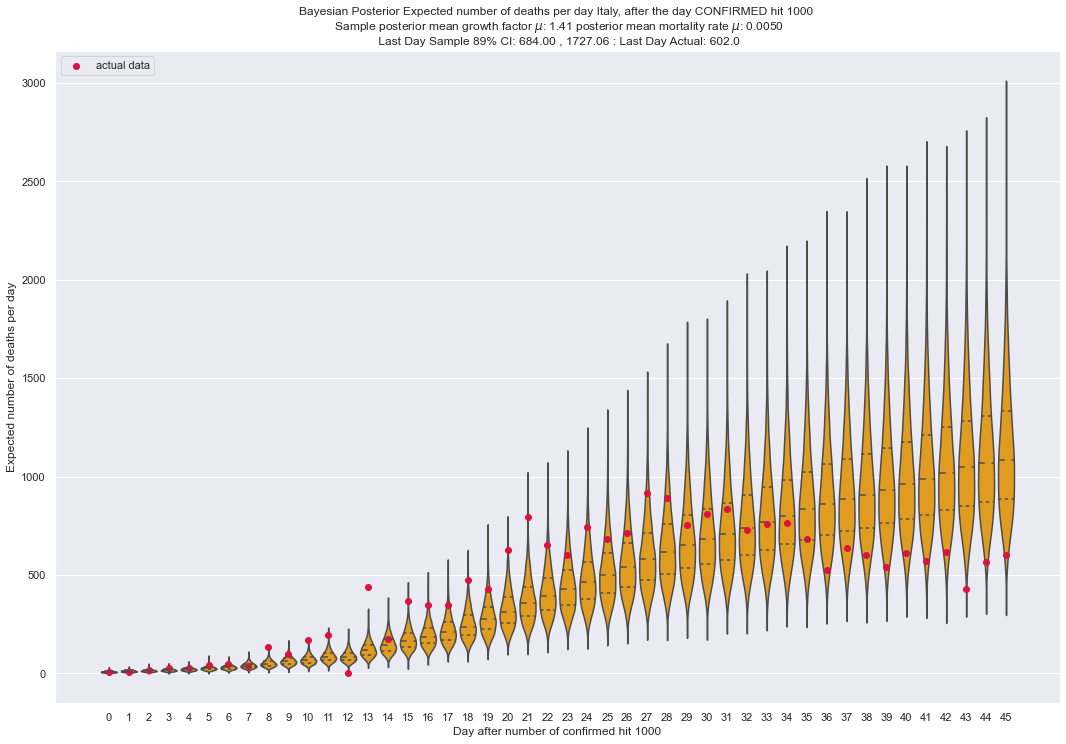

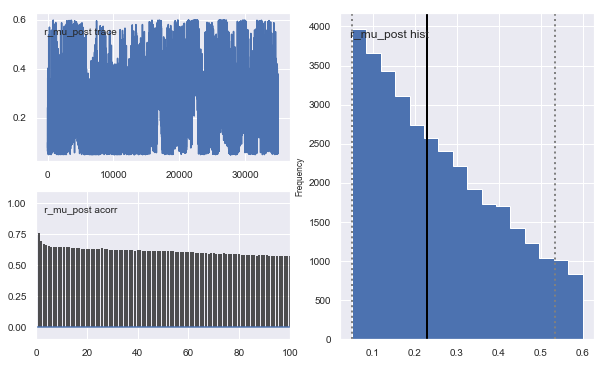

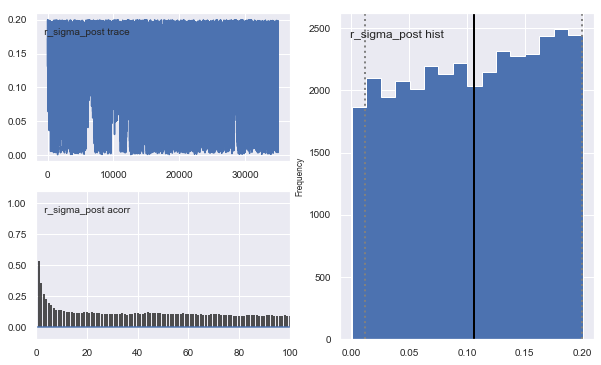

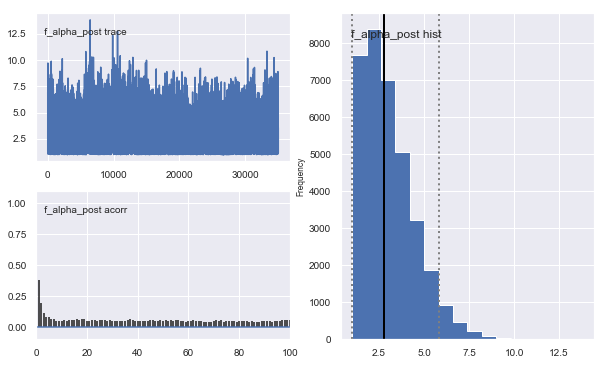

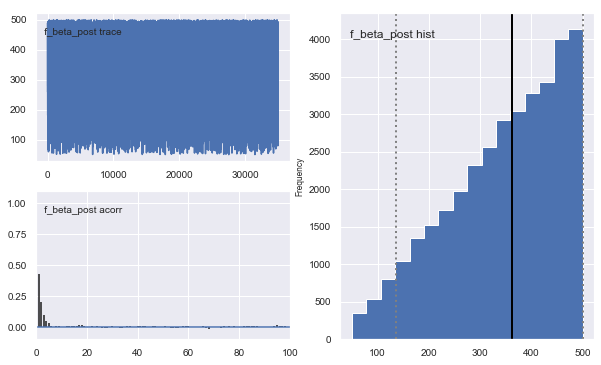

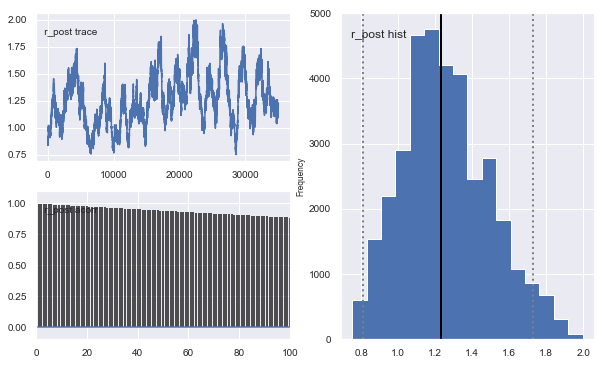

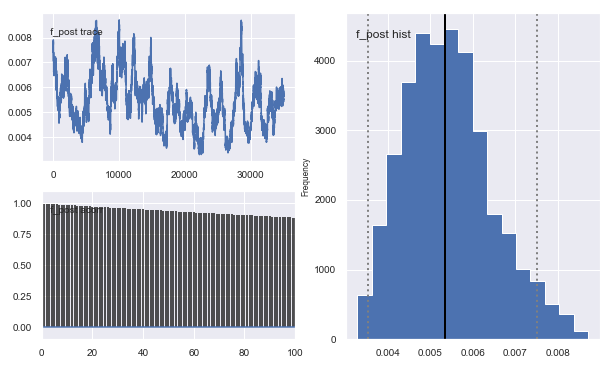

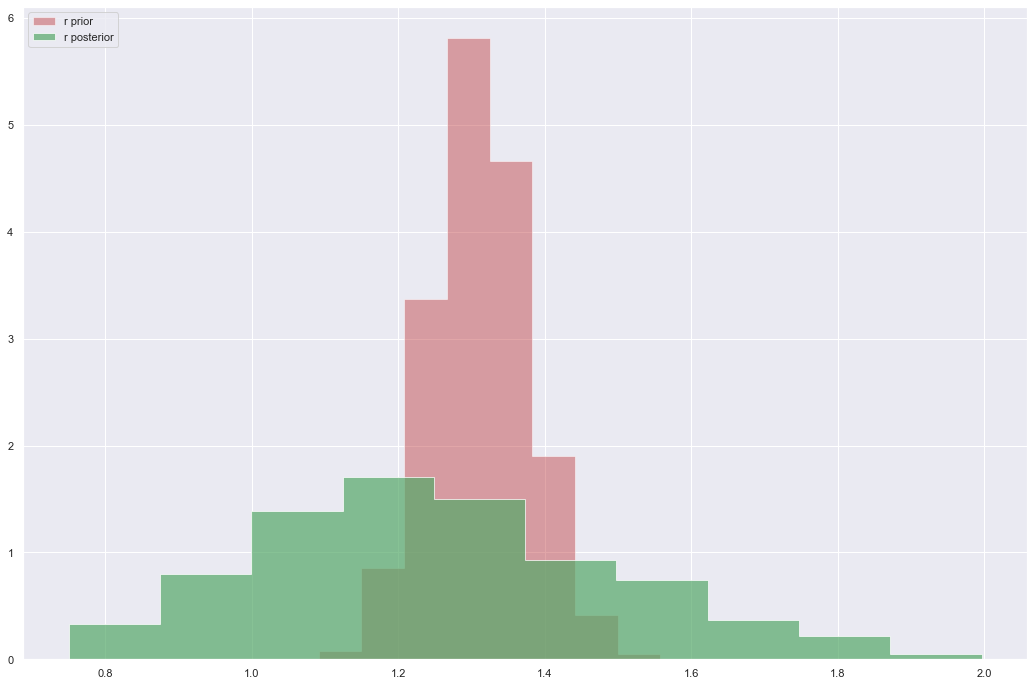

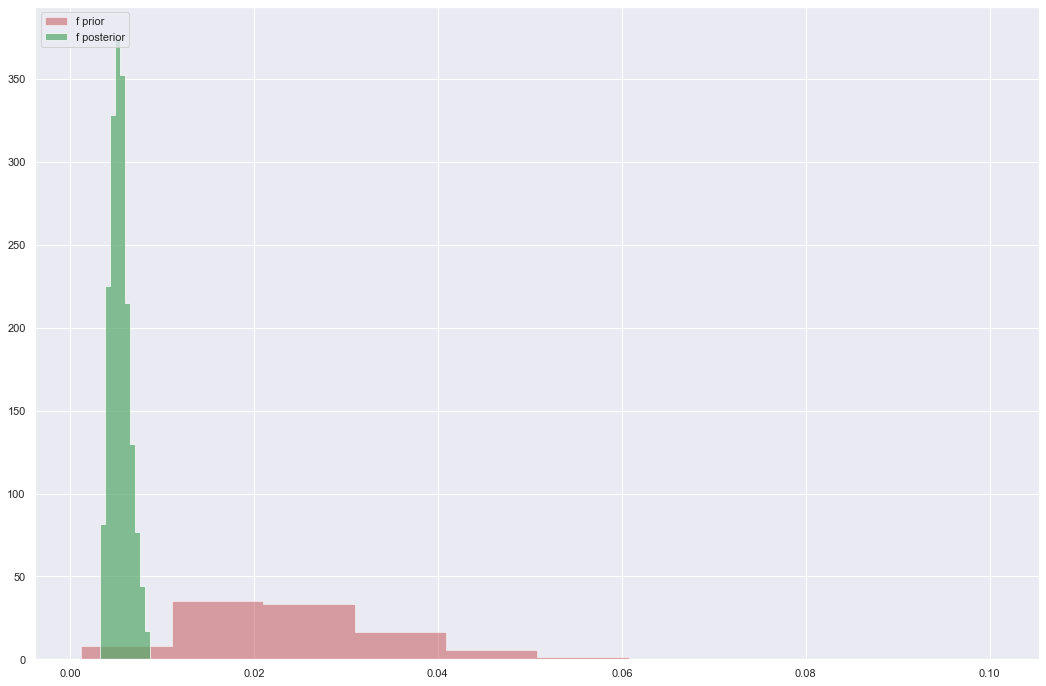

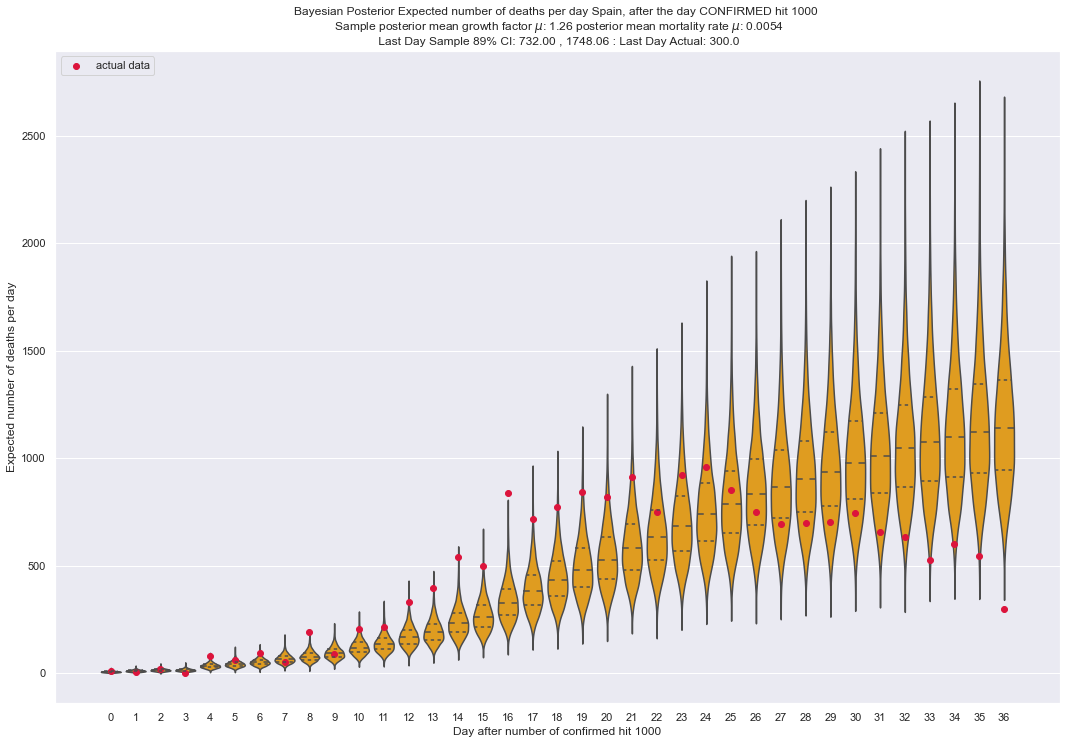

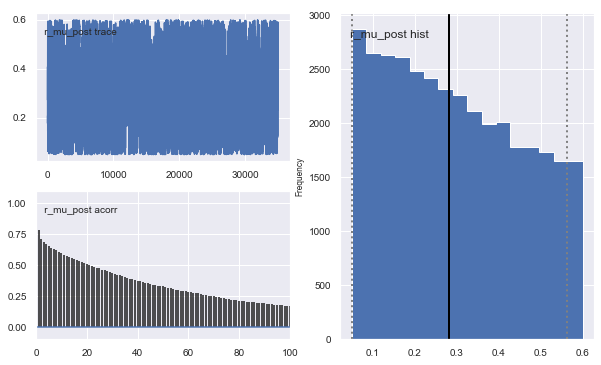

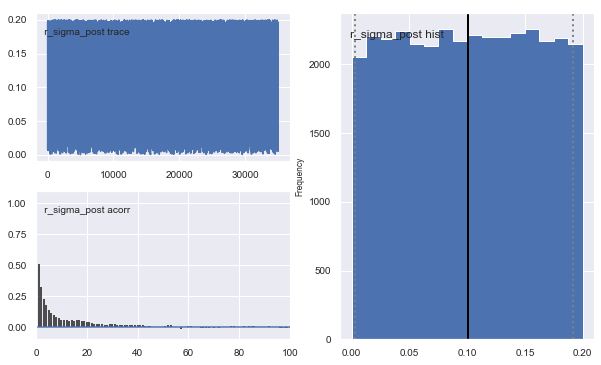

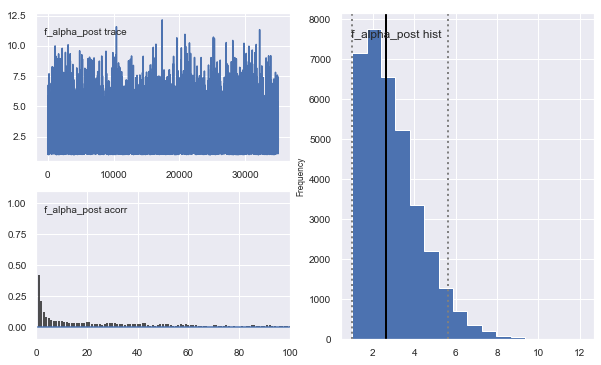

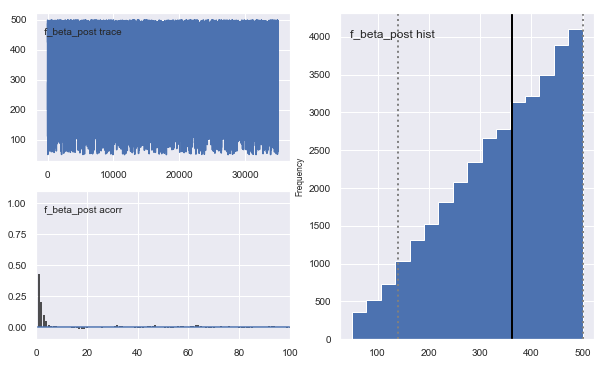

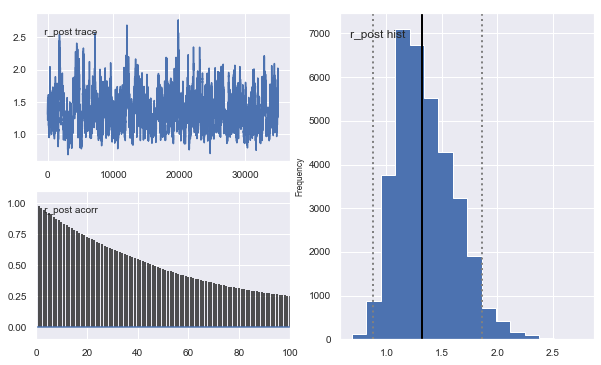

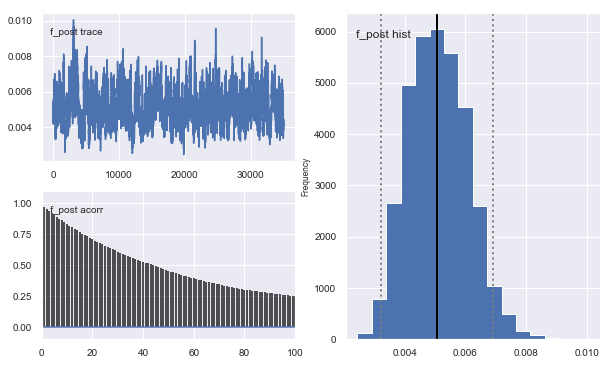

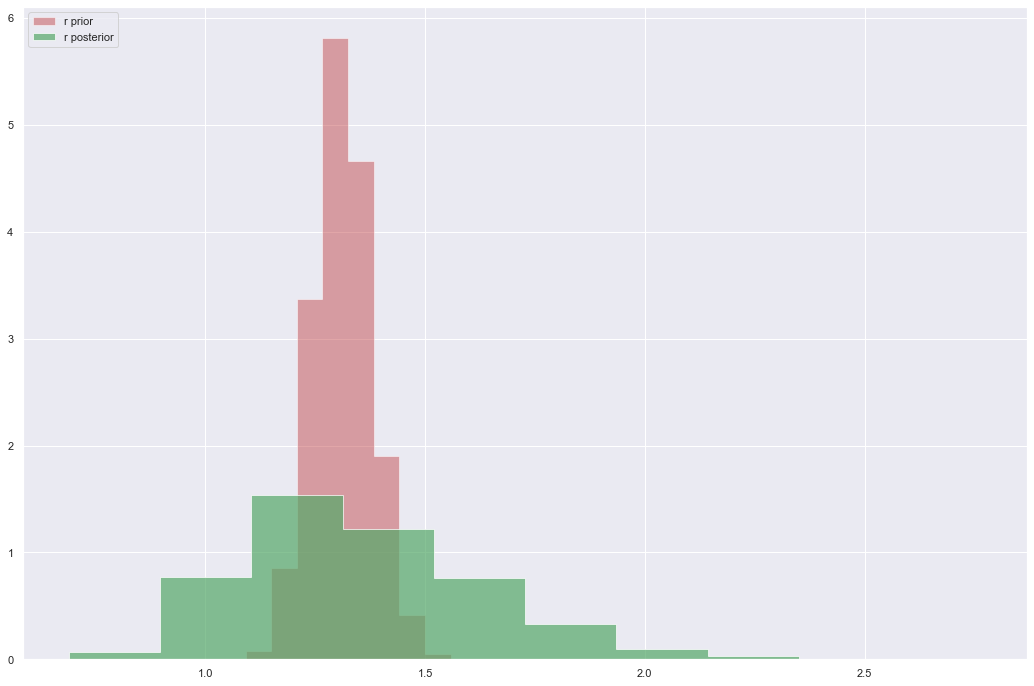

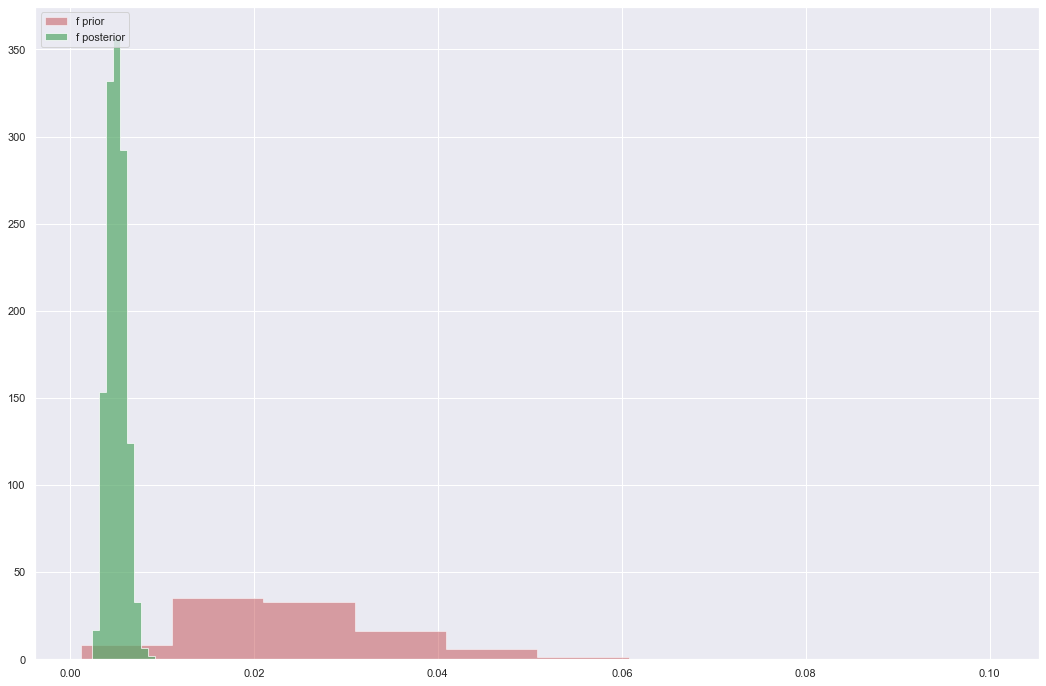

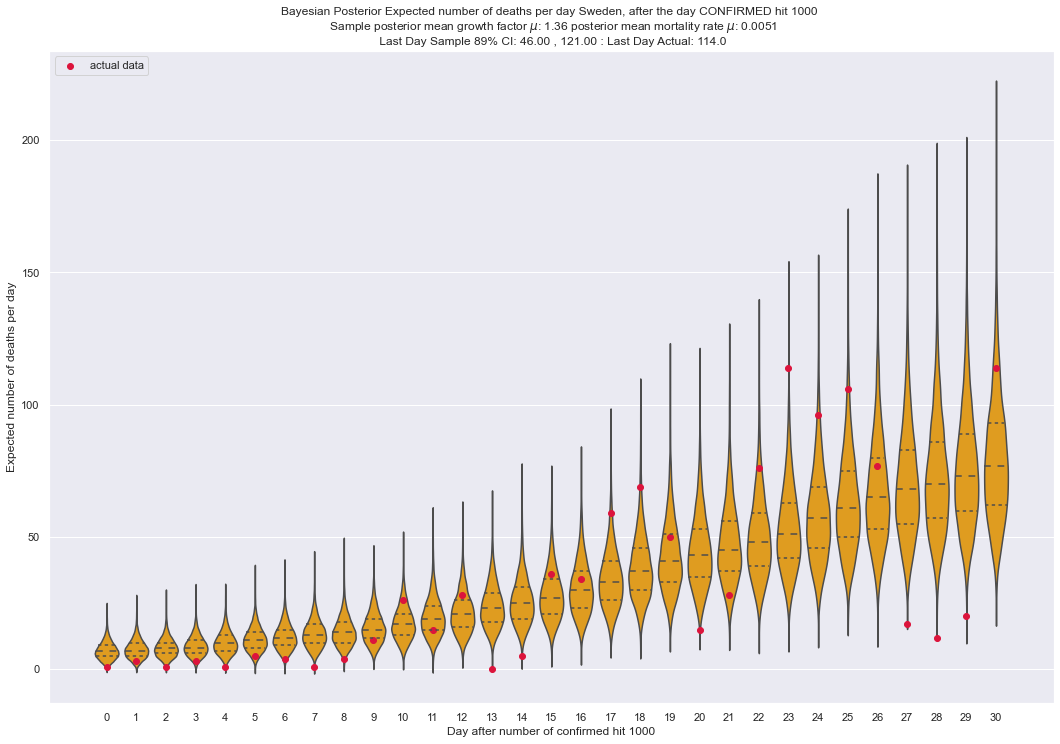

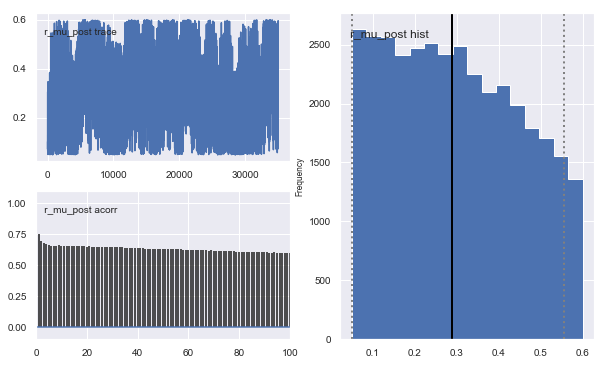

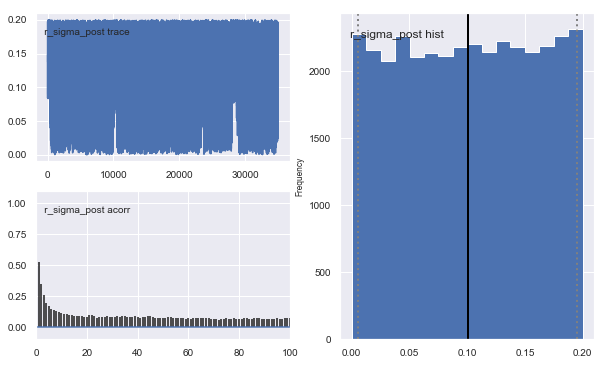

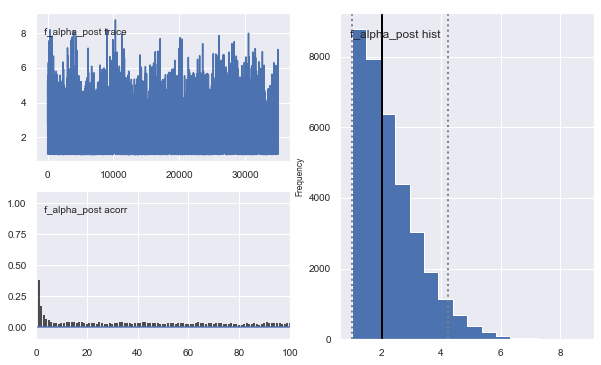

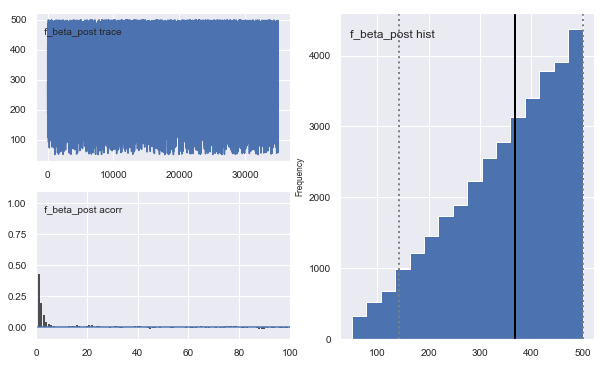

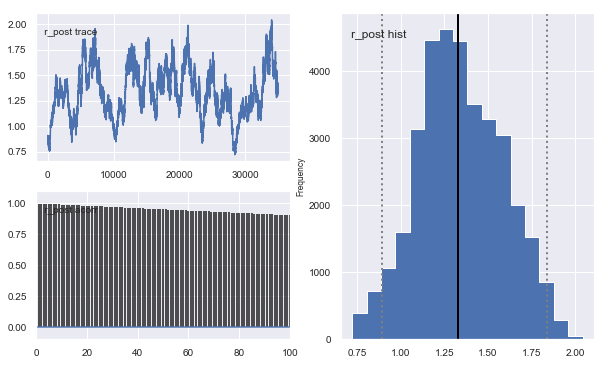

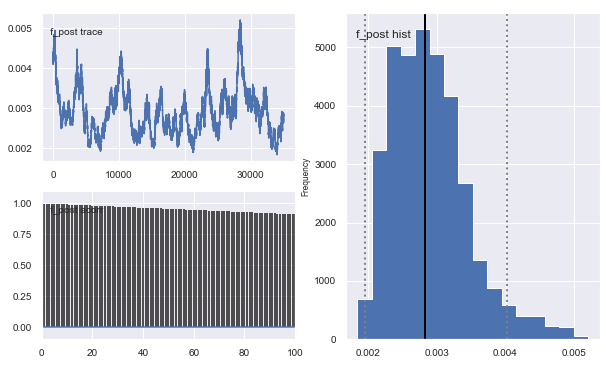

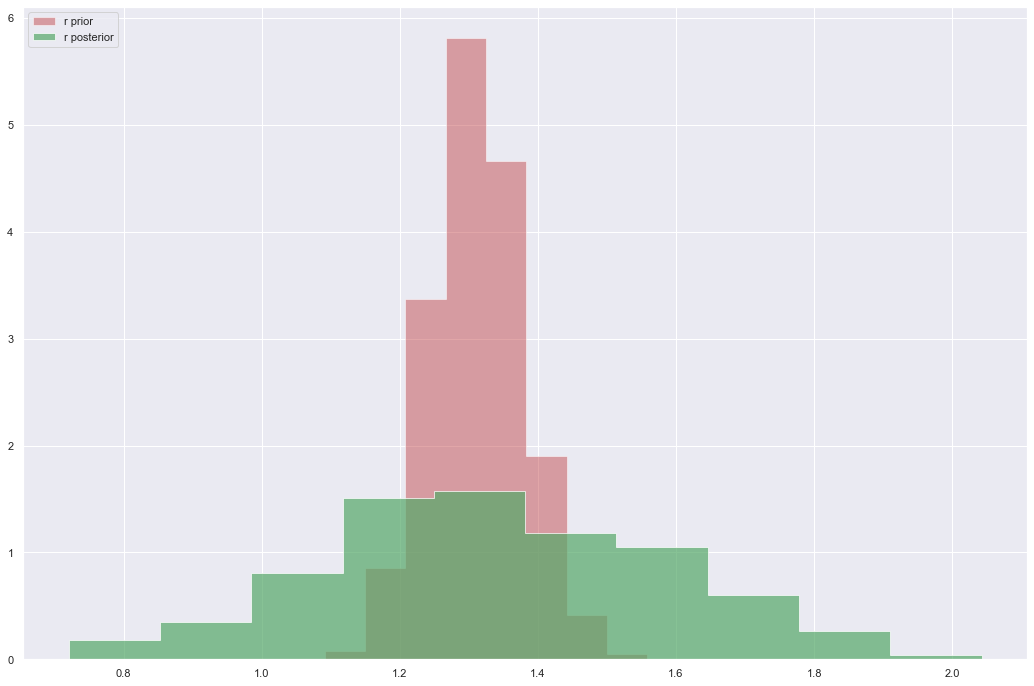

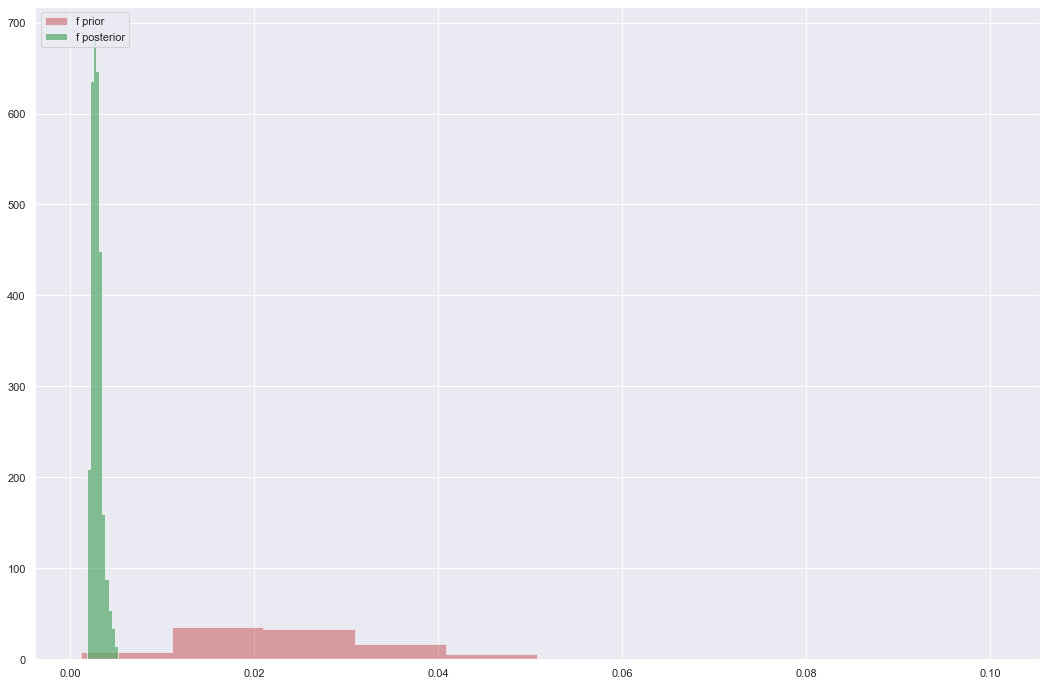

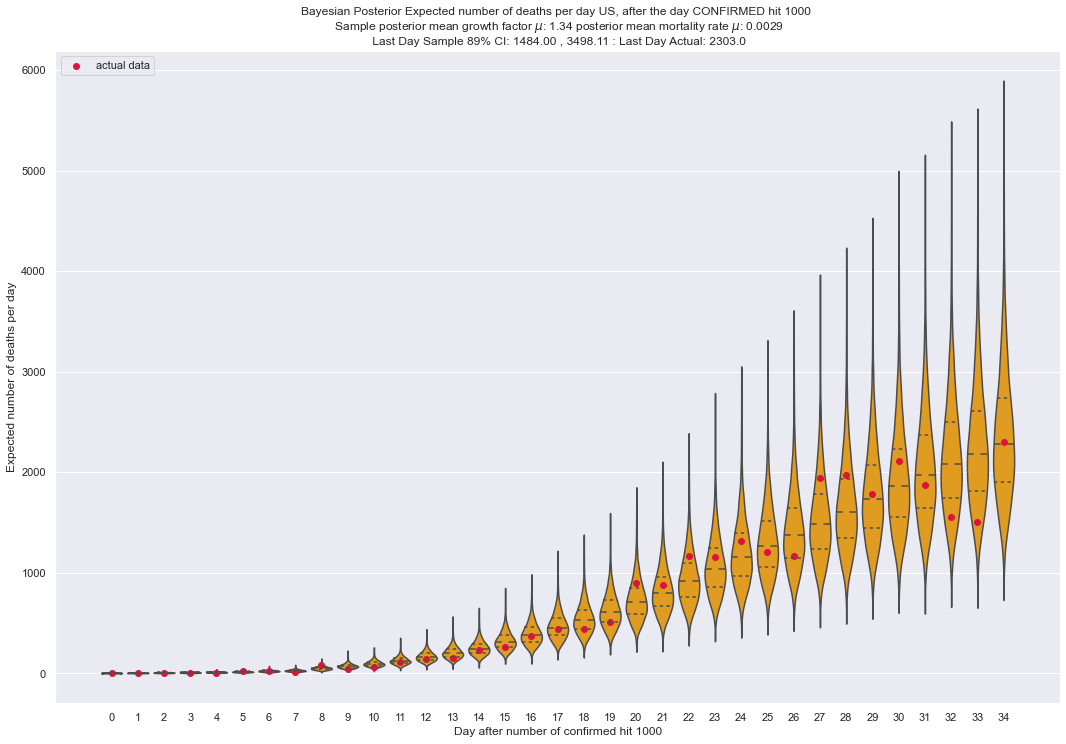

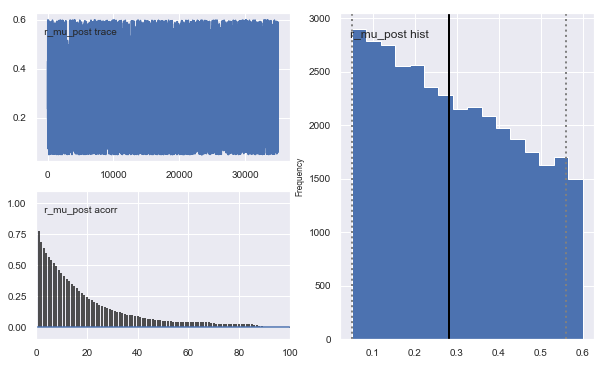

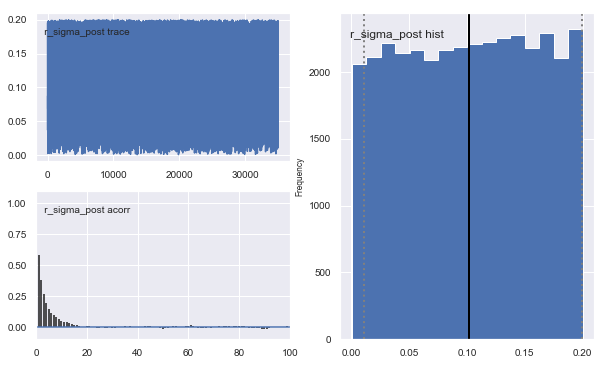

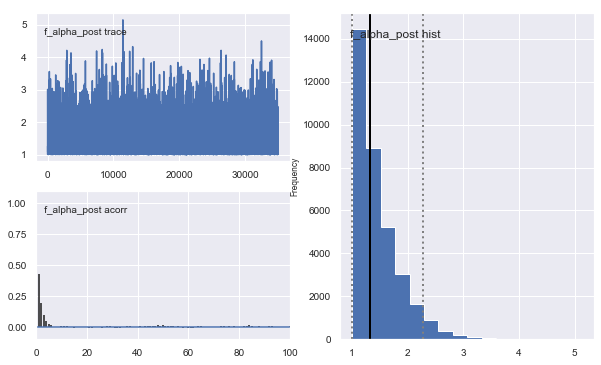

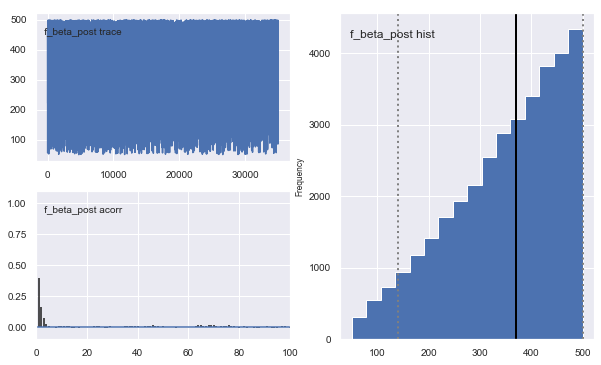

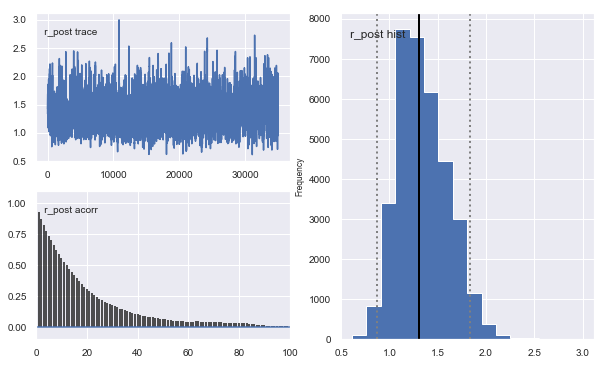

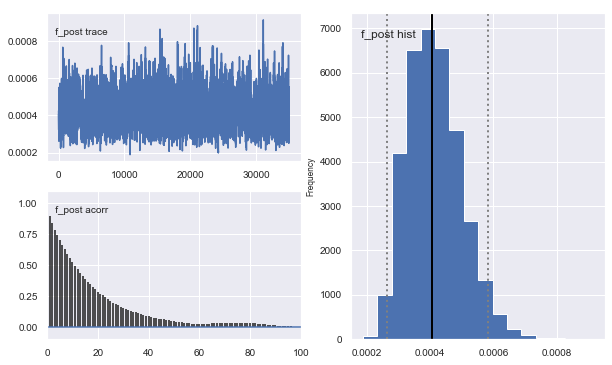

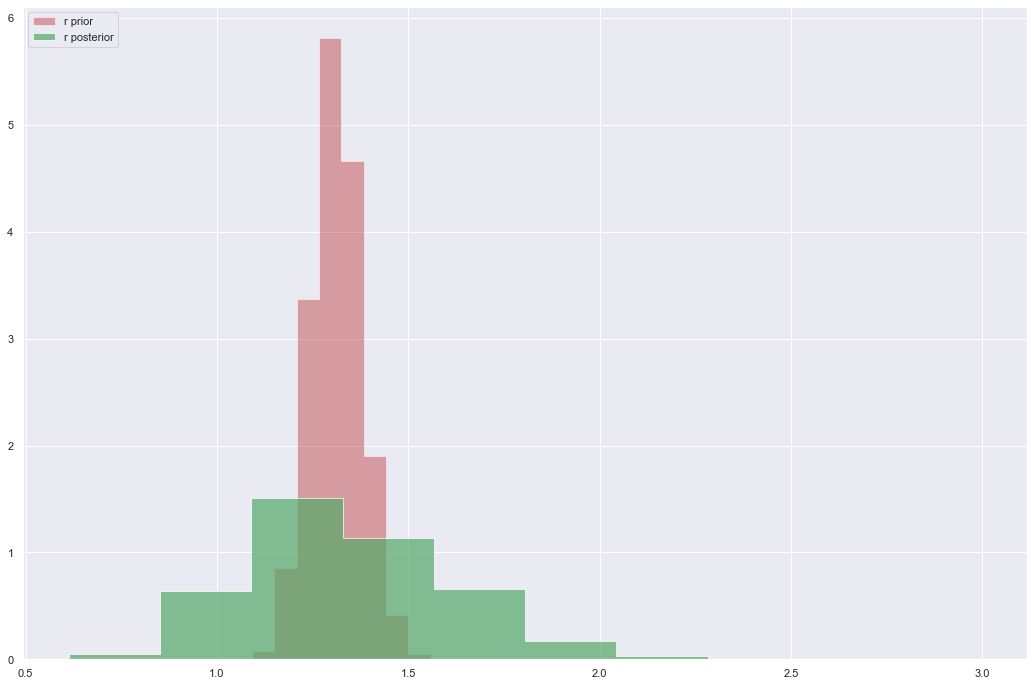

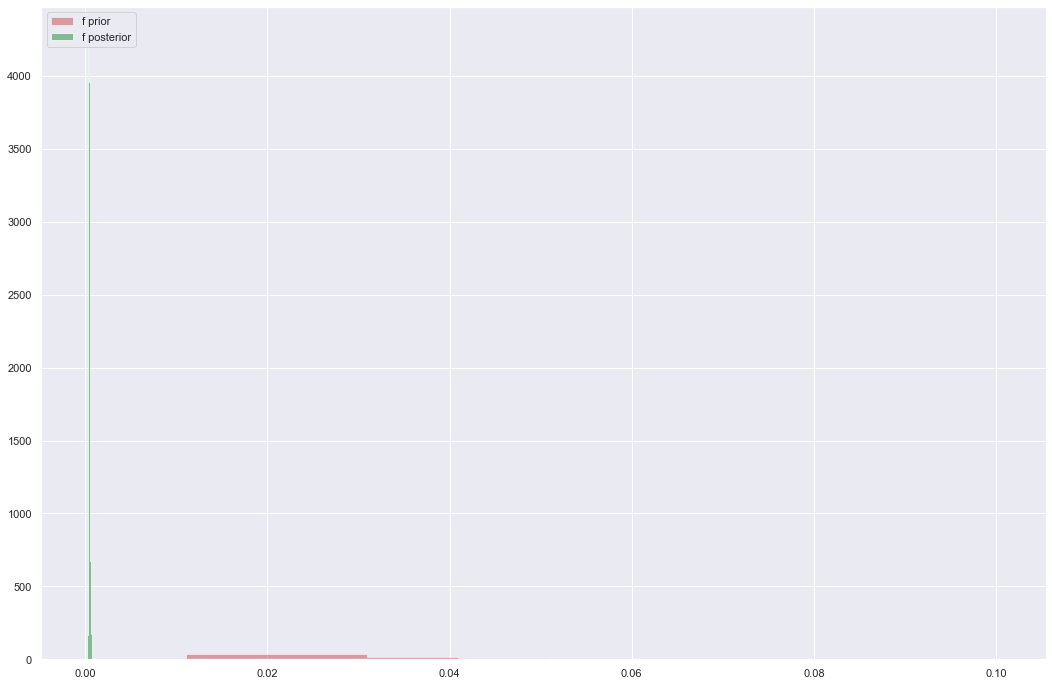

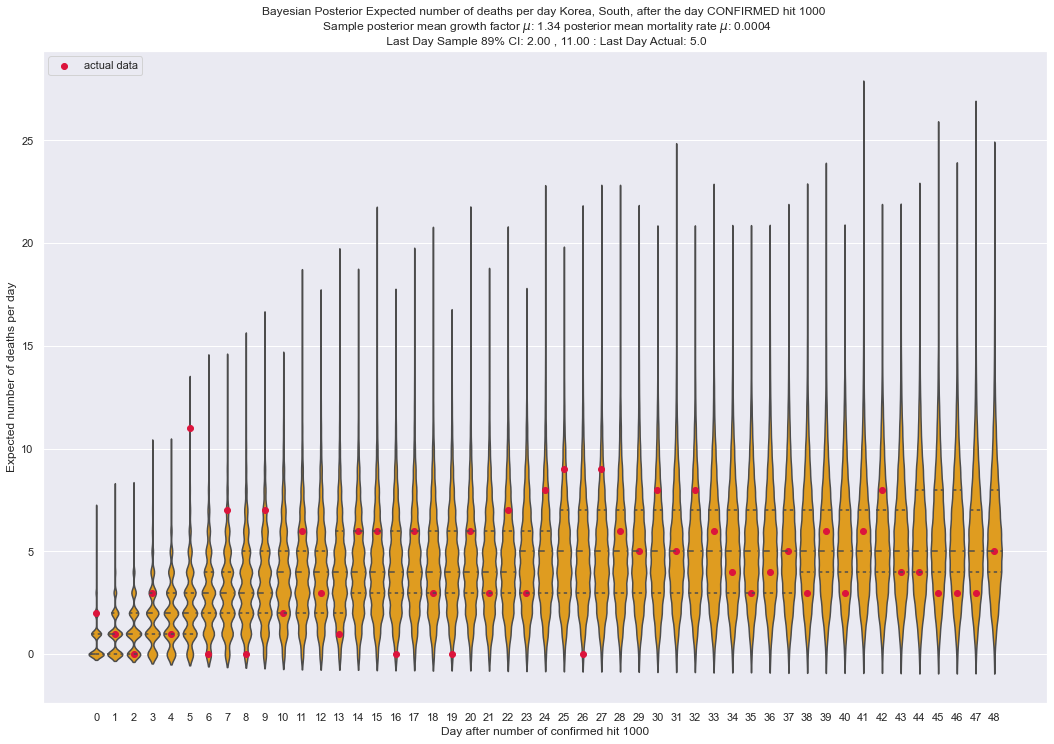

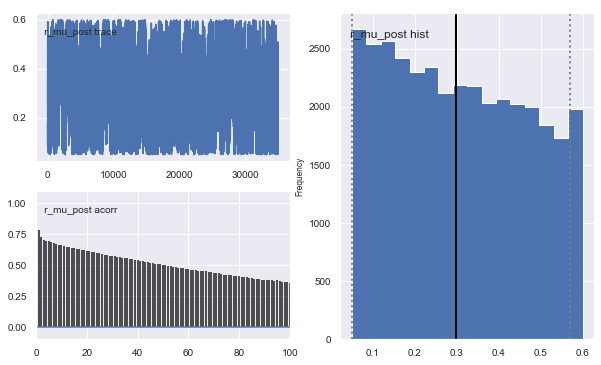

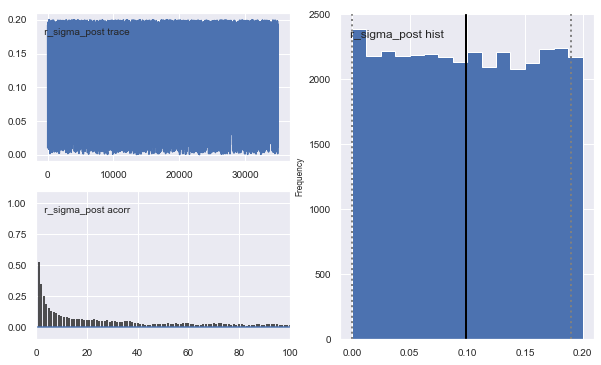

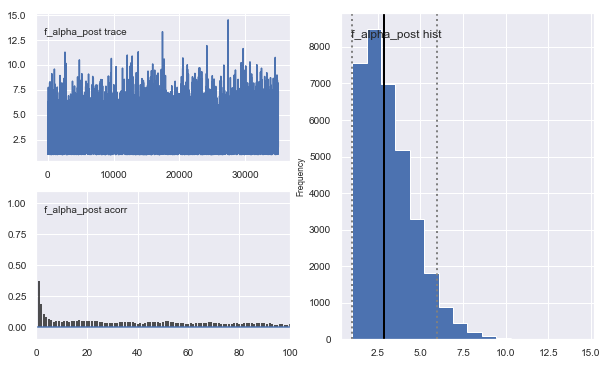

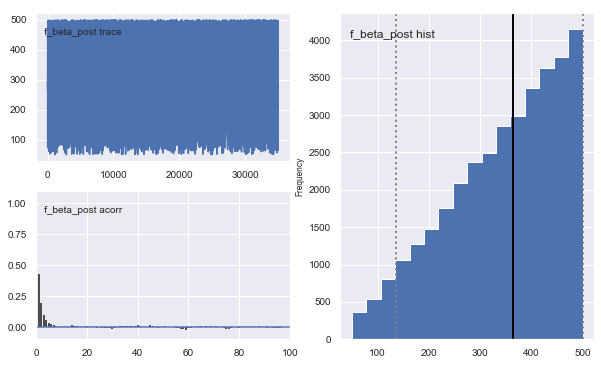

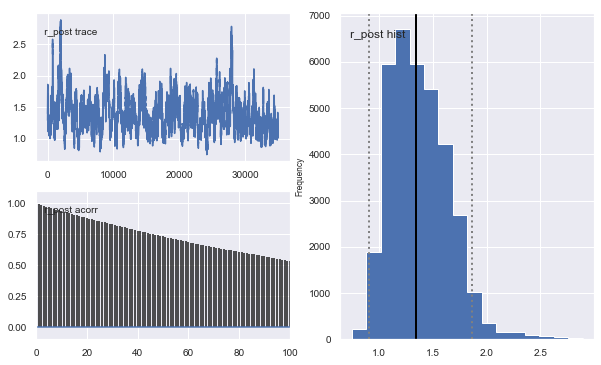

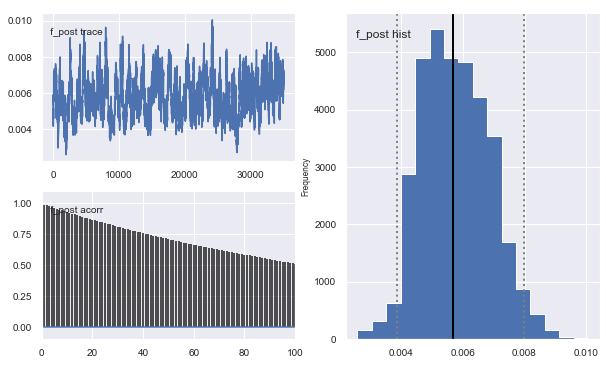

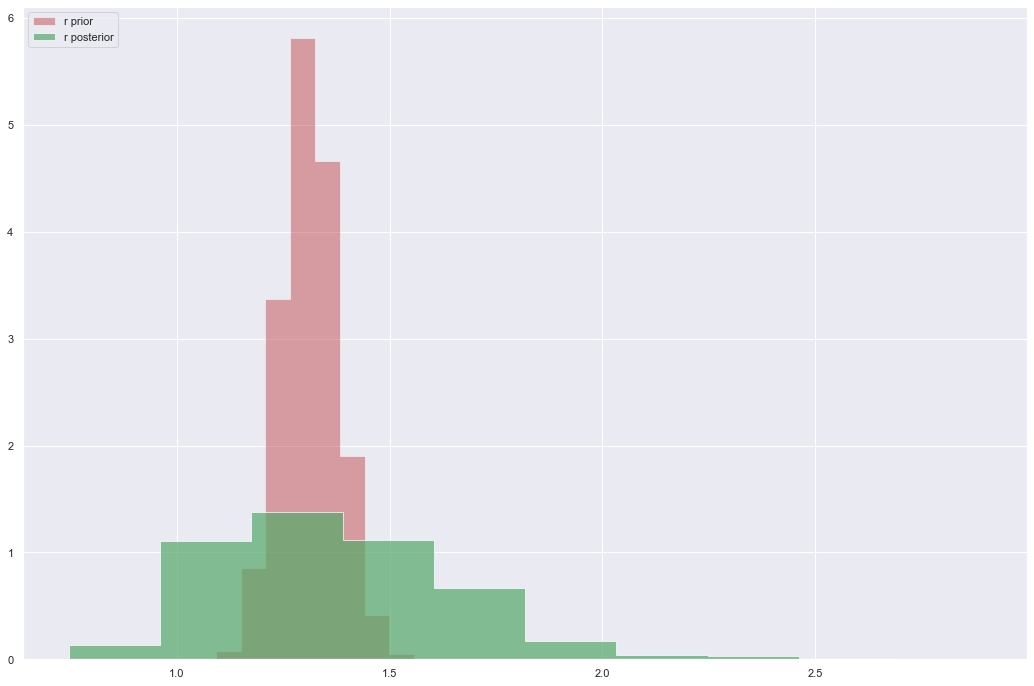

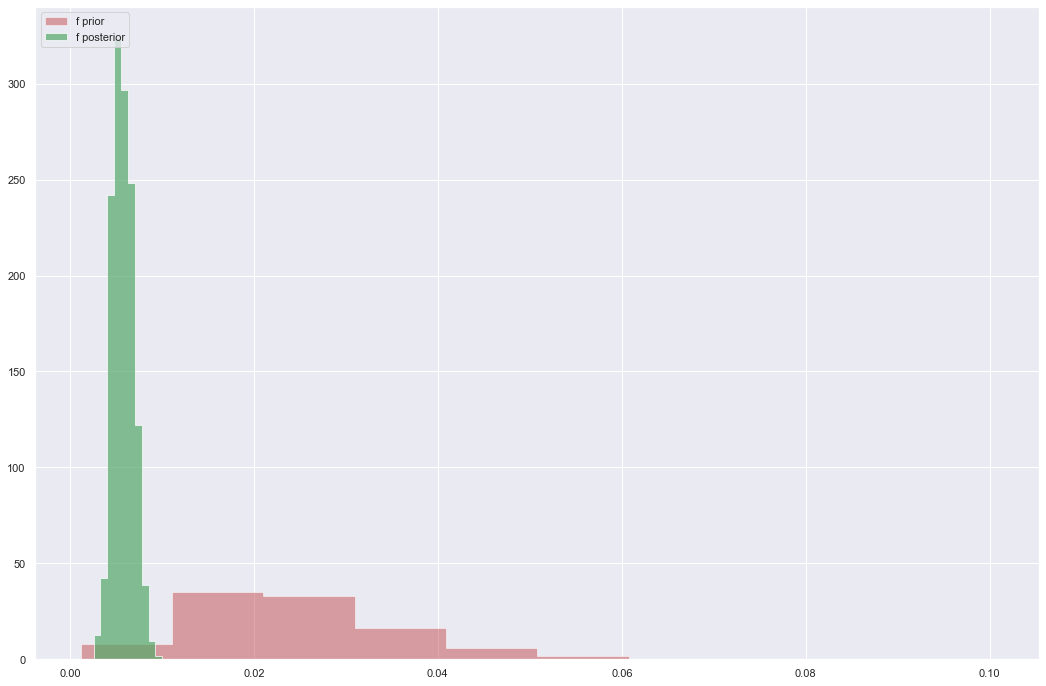

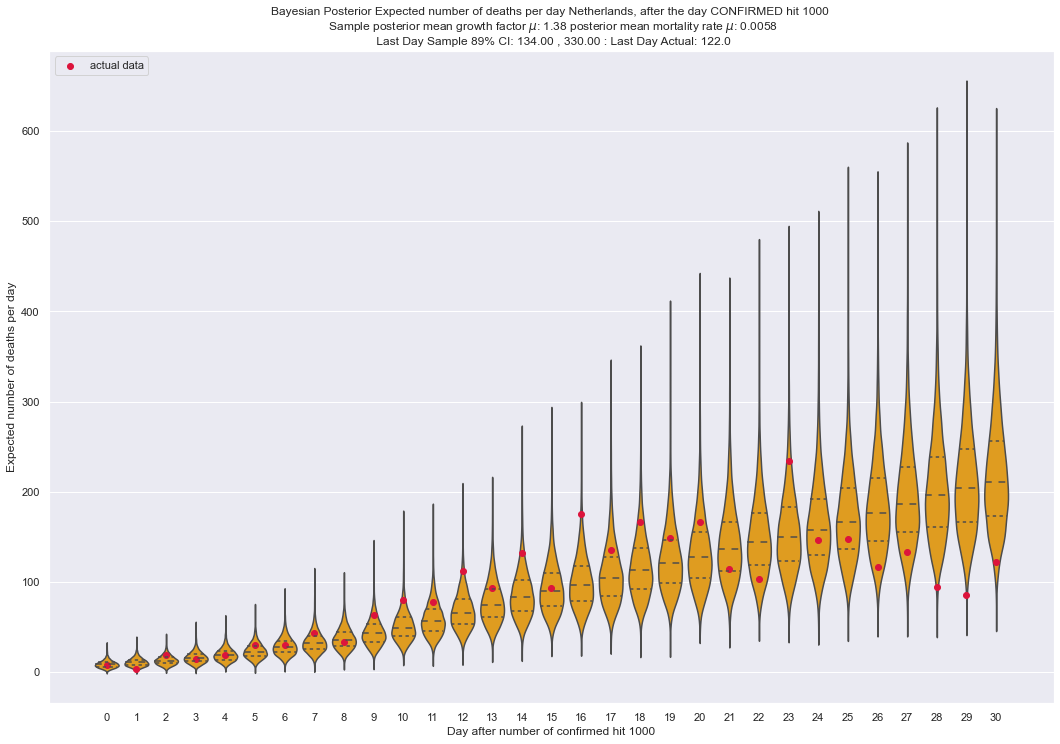

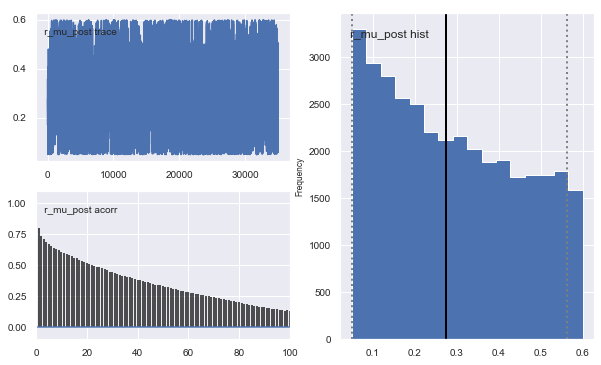

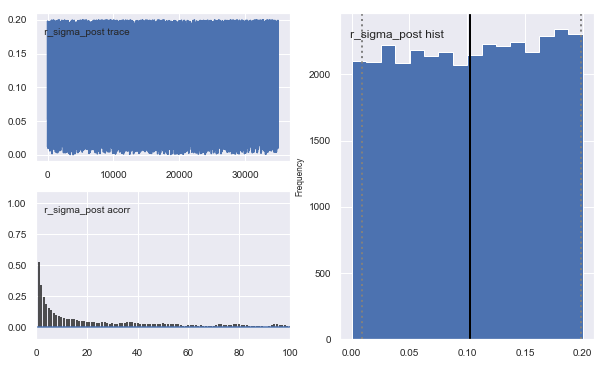

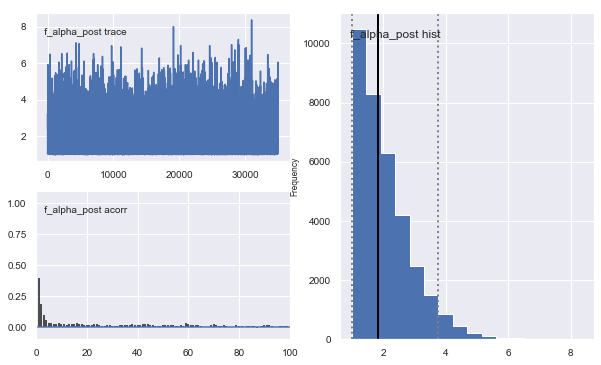

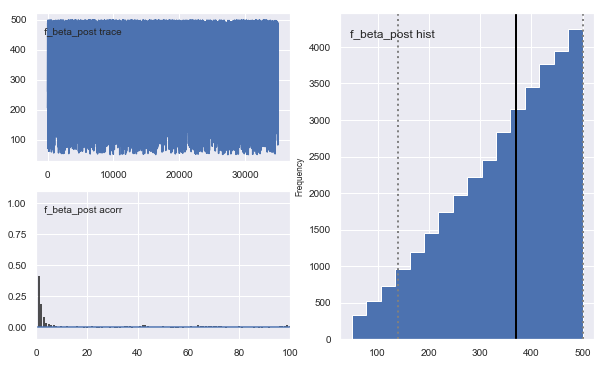

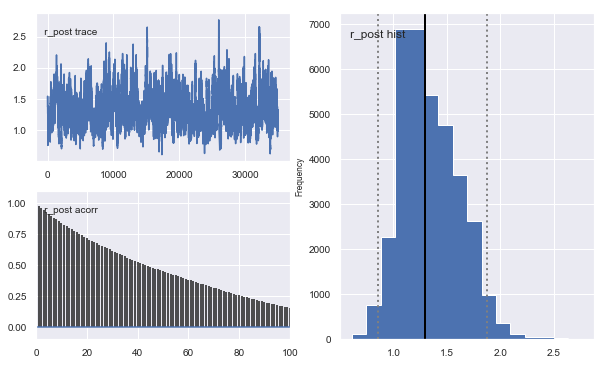

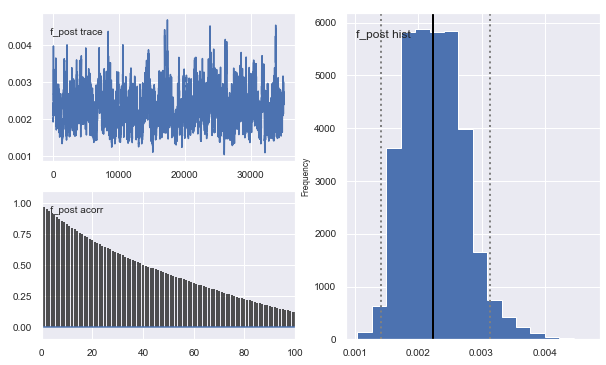

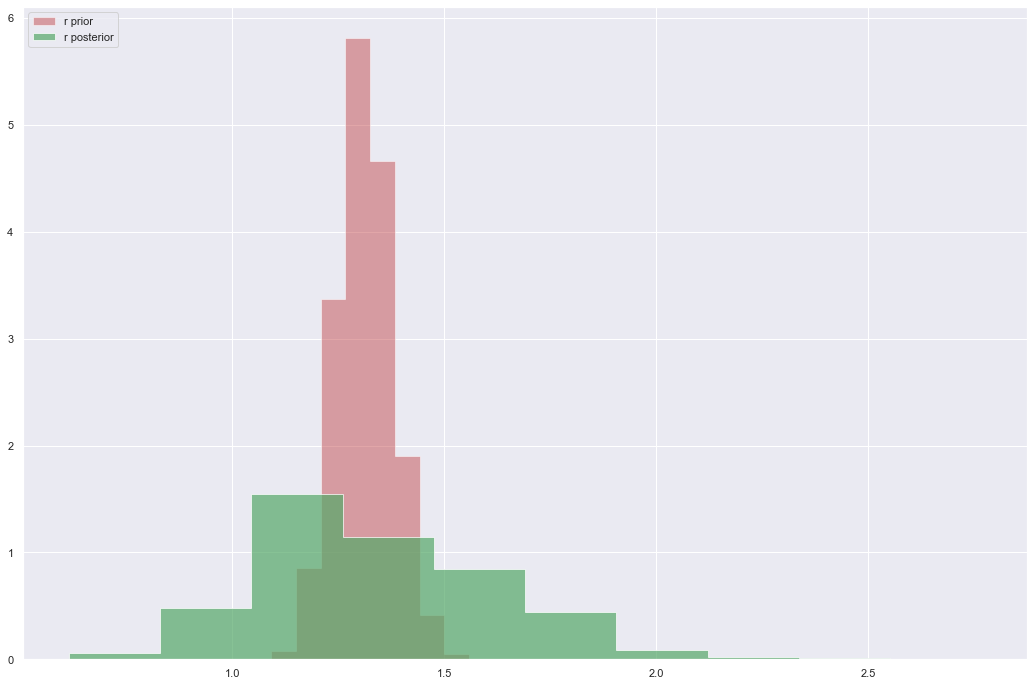

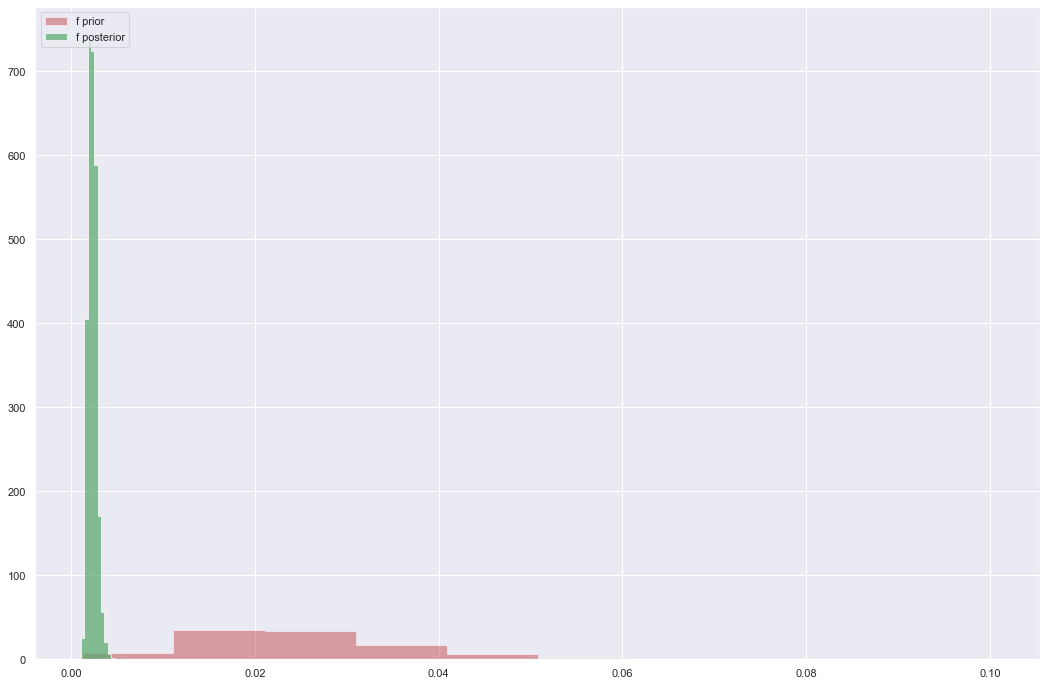

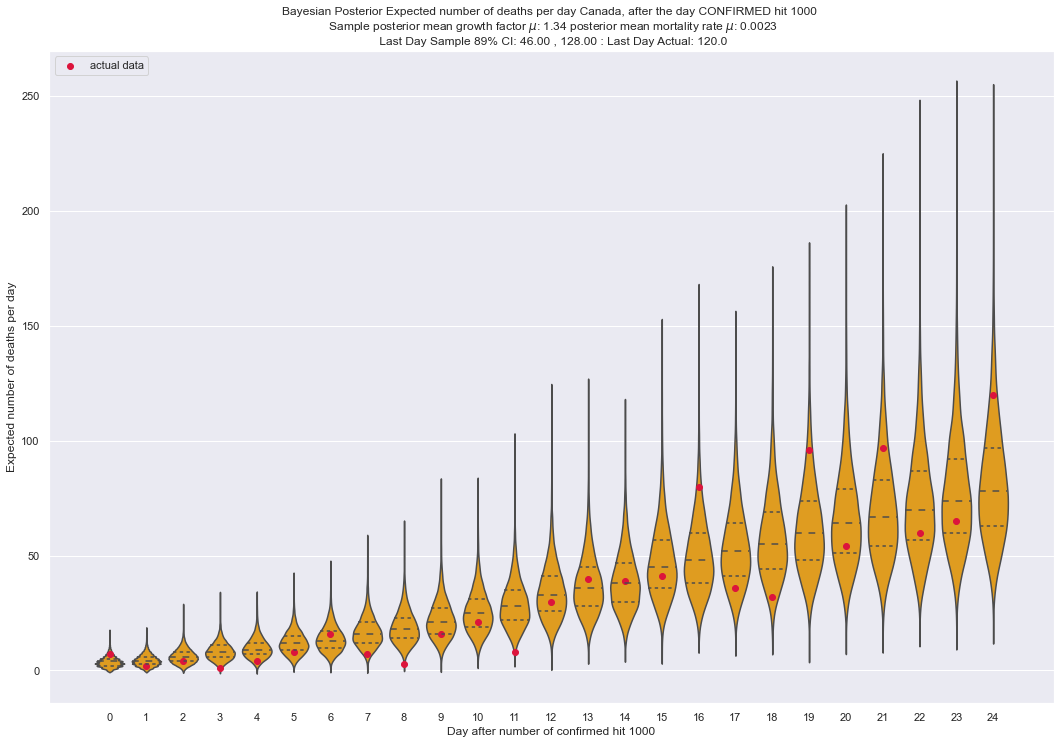

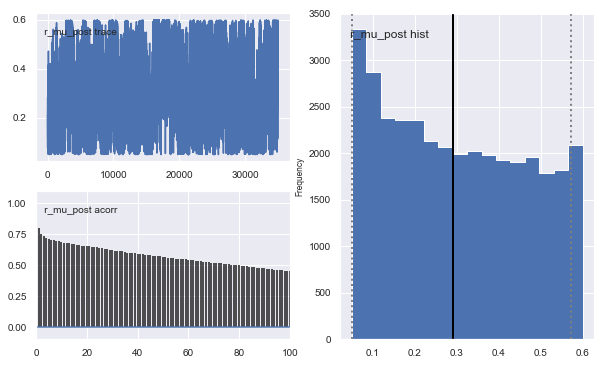

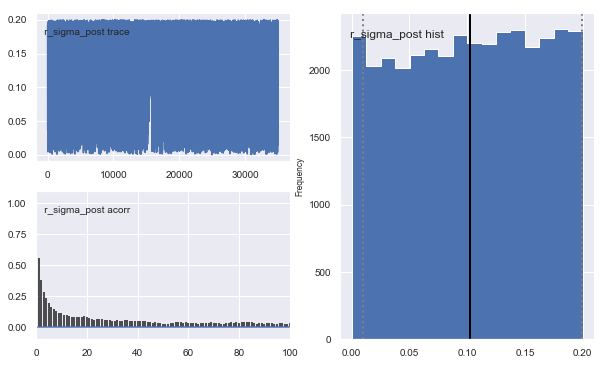

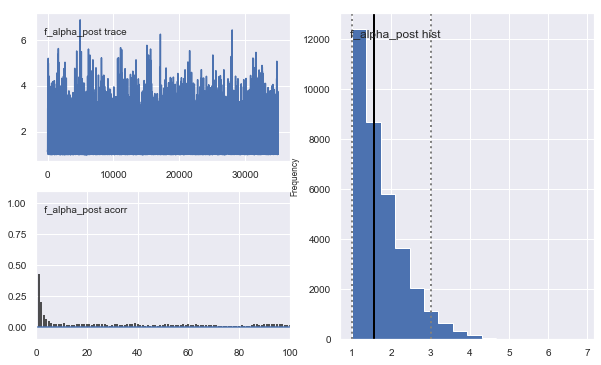

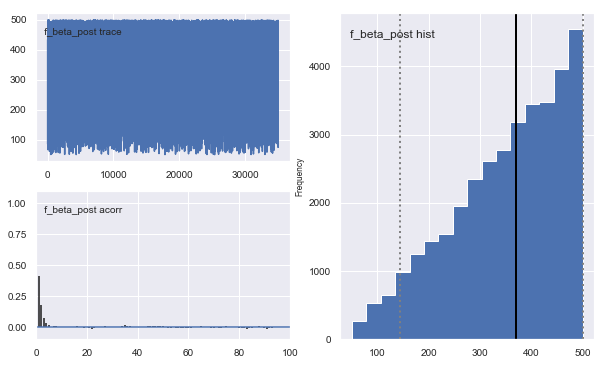

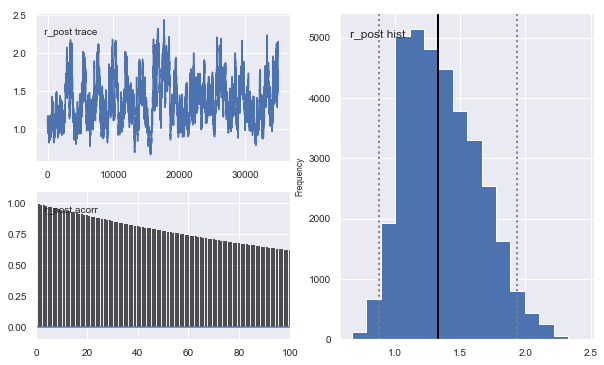

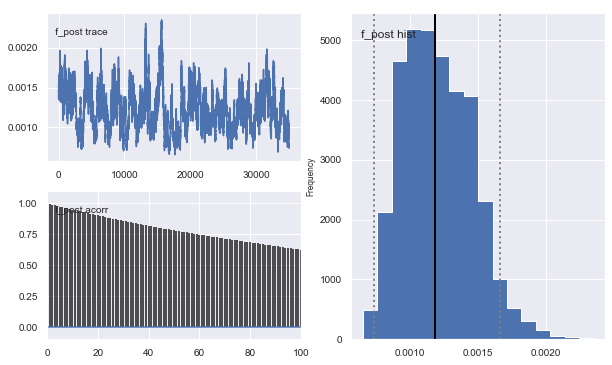

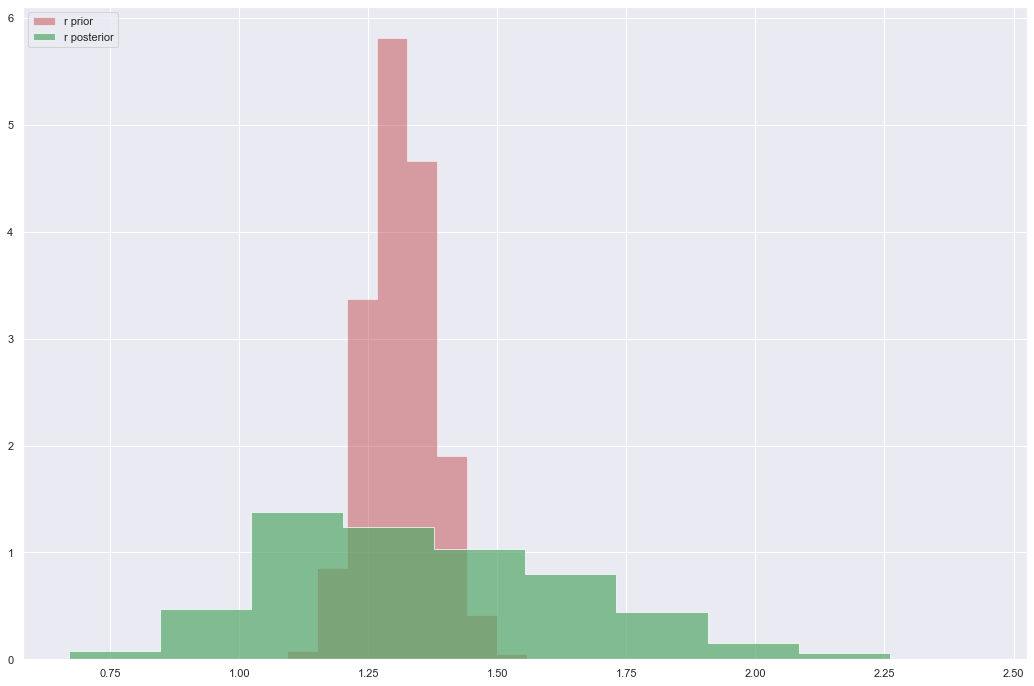

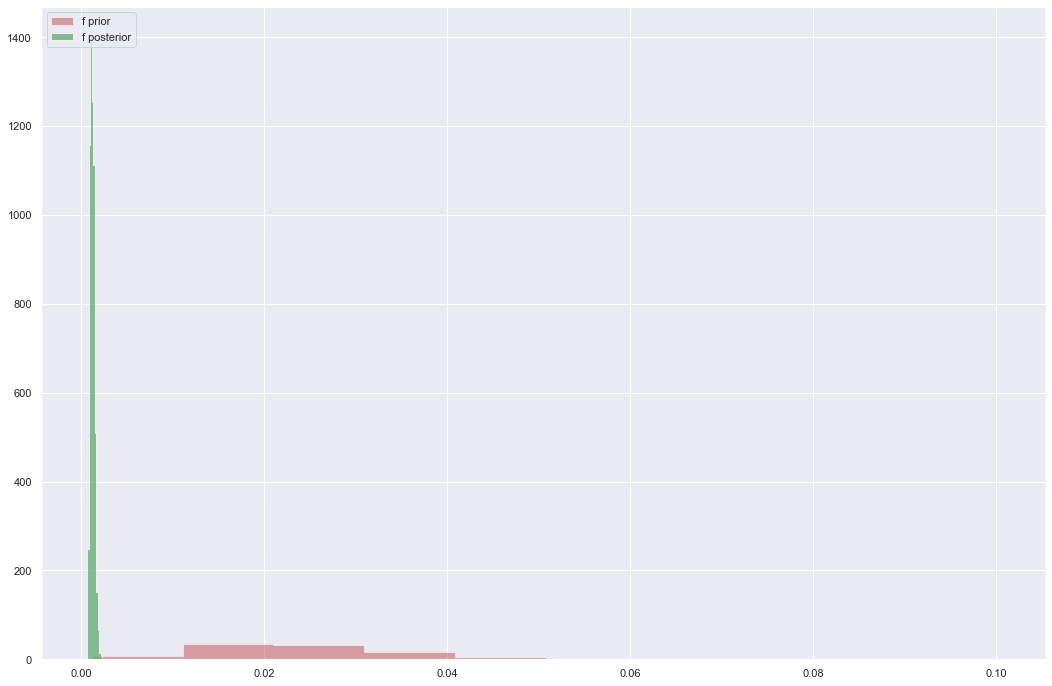

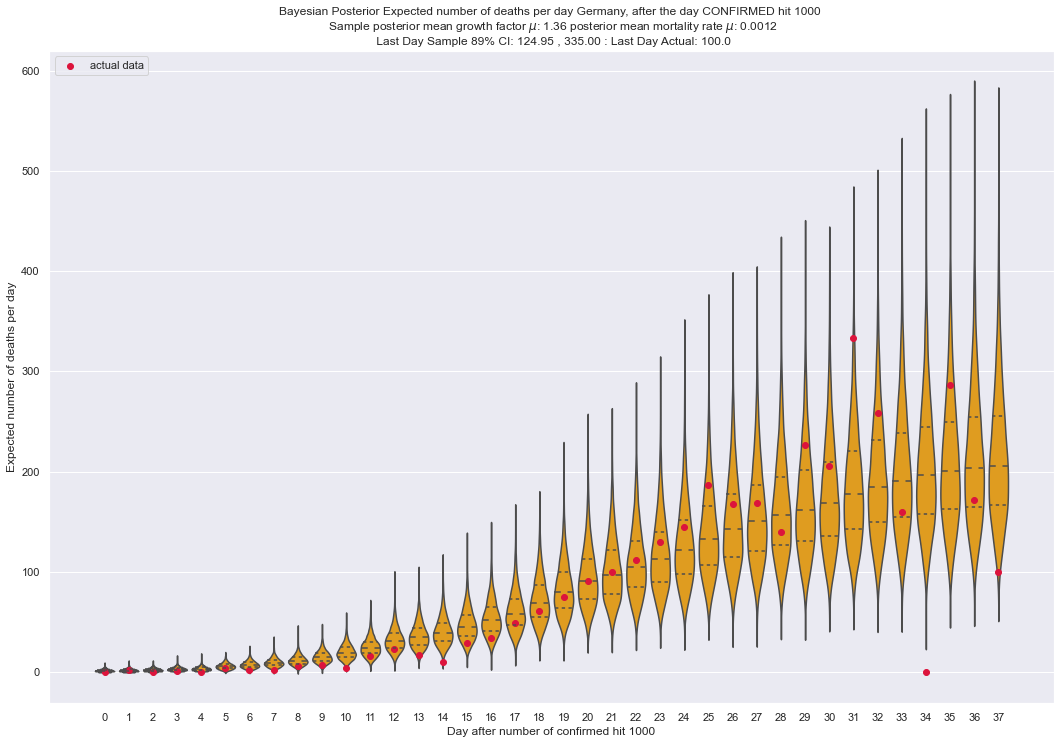

In [113]:
countries = ['India','Italy','Spain','Sweden','US',
             'Korea, South','Netherlands','Canada','Germany']

#countries = ['United Kingdom','France','Austria','Turkey']
#countries = ['Germany']


for country_name in countries:
    
    df = process_country(country_name)

    limit = 1000
    mask = df['confirmed'] >= limit
    df = df[mask]

    #df = df[-10:]

    print ()
    print ('++++++++++++++++++++++ {} +++++++++++++++++++++++'.format(country_name))
    print (df.tail())

    D = df['dead_inc']
    C = df['confirmed']
    
    result = inference(df,C,D,country_name)
    sample_df = create_posterior_samples(result)
    print ('sample_df.head()')
    print (sample_df.head(40))
    print ('Last day summary stats')
    sample_df.iloc[-1].describe()
    plot(result,df,sample_df,country_name)
    result.to_pickle('violin_daily_result_{}.pkl'.format(country_name.replace(' ','_')))

In [114]:
#plot(result,df,sample_df,country_name)


In [115]:
US = pd.read_pickle('us_state_dict.pkl')

In [116]:
ny = US['New York']
ny = ny[['confirmed','deceased','recovered','inc','factor','dead_inc','dead_factor']]
ny

confirmed  deceased  recovered      inc    factor  dead_inc  \
date                                                                      
2020-03-10      173.0       0.0        0.0      NaN       NaN       NaN   
2020-03-11      220.0       0.0        0.0     47.0  1.271676       0.0   
2020-03-12      328.0       0.0        0.0    108.0  1.490909       0.0   
2020-03-13      421.0       0.0        0.0     93.0  1.283537       0.0   
2020-03-14      525.0       2.0        0.0    104.0  1.247031       2.0   
2020-03-15      732.0       3.0        0.0    207.0  1.394286       1.0   
2020-03-16      967.0      10.0        0.0    235.0  1.321038       7.0   
2020-03-17     1706.0      13.0        0.0    739.0  1.764219       3.0   
2020-03-18     2495.0      16.0        0.0    789.0  1.462485       3.0   
2020-03-19     5365.0      34.0        0.0   2870.0  2.150301      18.0   
2020-03-20     8310.0      42.0        0.0   2945.0  1.548928       8.0   
2020-03-21    11710.0      60.0        0.0   3400.0  1.409146      18.0   
2020-03-22    15800.0     117.0        0.0   4090.0  1.349274      57.0   
2020-03-23    20884.0     158.0        0.0   5084.0  1.321772      41.0   
2020-03-24    25681.0     210.0        0.0   4797.0  1.229697      52.0   
2020-03-25    30841.0     285.0        0.0   5160.0  1.200927      75.0   
2020-03-26    37877.0     385.0        0.0   7036.0  1.228138     100.0   
2020-03-27    44876.0     527.0        0.0   6999.0  1.184782     142.0   
2020-03-28    52410.0     728.0        0.0   7534.0  1.167885     201.0   
2020-03-29    59648.0     965.0        0.0   7238.0  1.138103     237.0   
2020-03-30    66663.0    1218.0        0.0   7015.0  1.117607     253.0   
2020-03-31    75833.0    1550.0        0.0   9170.0  1.137558     332.0   
2020-04-01    83948.0    1941.0        0.0   8115.0  1.107011     391.0   
2020-04-02    92506.0    2373.0        0.0   8558.0  1.101944     432.0   
2020-04-03   102987.0    2935.0        0.0  10481.0  1.113301     562.0   
2020-04-04   113833.0    3565.0        0.0  10846.0  1.105314     630.0   
2020-04-05   123160.0    4159.0        0.0   9327.0  1.081936     594.0   
2020-04-06   131815.0    4698.0        0.0   8655.0  1.070274     539.0   
2020-04-07   139875.0    5489.0        0.0   8060.0  1.061146     791.0   
2020-04-08   151061.0    6268.0        0.0  11186.0  1.079971     779.0   
2020-04-09   161779.0    7067.0        0.0  10718.0  1.070951     799.0   
2020-04-10   172348.0    7867.0        0.0  10569.0  1.065330     800.0   
2020-04-11   181026.0    8627.0        0.0   8678.0  1.050352     760.0   
2020-04-12   189033.0    9385.0        0.0   8007.0  1.044231     758.0   
2020-04-13   195749.0   10058.0        0.0   6716.0  1.035528     673.0   
2020-04-14   203020.0   10842.0        0.0   7271.0  1.037145     784.0   

            dead_factor  
date                     
2020-03-10          NaN  
2020-03-11          NaN  
2020-03-12          NaN  
2020-03-13          NaN  
2020-03-14          NaN  
2020-03-15     1.500000  
2020-03-16     3.333333  
2020-03-17     1.300000  
2020-03-18     1.230769  
2020-03-19     2.125000  
2020-03-20     1.235294  
2020-03-21     1.428571  
2020-03-22     1.950000  
2020-03-23     1.350427  
2020-03-24     1.329114  
2020-03-25     1.357143  
2020-03-26     1.350877  
2020-03-27     1.368831  
2020-03-28     1.381404  
2020-03-29     1.325549  
2020-03-30     1.262176  
2020-03-31     1.272578  
2020-04-01     1.252258  
2020-04-02     1.222566  
2020-04-03     1.236831  
2020-04-04     1.214651  
2020-04-05     1.166620  
2020-04-06     1.129598  
2020-04-07     1.168370  
2020-04-08     1.141920  
2020-04-09     1.127473  
2020-04-10     1.113202  
2020-04-11     1.096606  
2020-04-12     1.087864  
2020-04-13     1.071710  
2020-04-14     1.077948

            confirmed  deceased  recovered      inc    factor  dead_inc  \
date                                                                      
2020-03-10      173.0       0.0        0.0      NaN       NaN       NaN   
2020-03-11      220.0       0.0        0.0     47.0  1.271676       0.0   
2020-03-12      328.0       0.0        0.0    108.0  1.490909       0.0   
2020-03-13      421.0       0.0        0.0     93.0  1.283537       0.0   
2020-03-14      525.0       2.0        0.0    104.0  1.247031       2.0   
2020-03-15      732.0       3.0        0.0    207.0  1.394286       1.0   
2020-03-16      967.0      10.0        0.0    235.0  1.321038       7.0   
2020-03-17     1706.0      13.0        0.0    739.0  1.764219       3.0   
2020-03-18     2495.0      16.0        0.0    789.0  1.462485       3.0   
2020-03-19     5365.0      34.0        0.0   2870.0  2.150301      18.0   
2020-03-20     8310.0      42.0        0.0   2945.0  1.548928       8.0   
2020-03-21    11710.0    

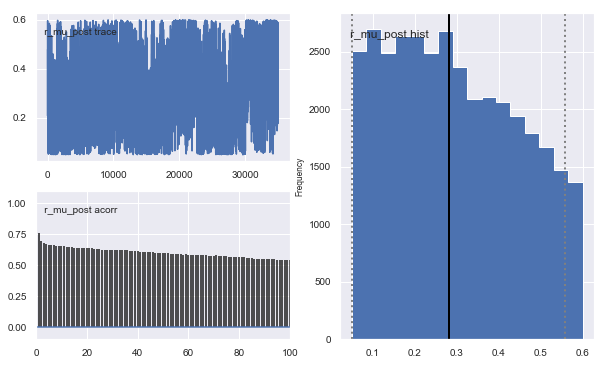

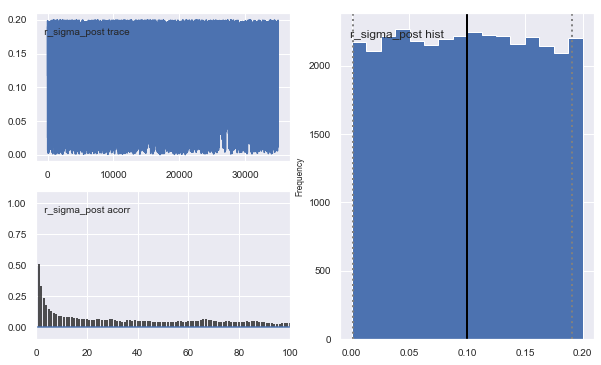

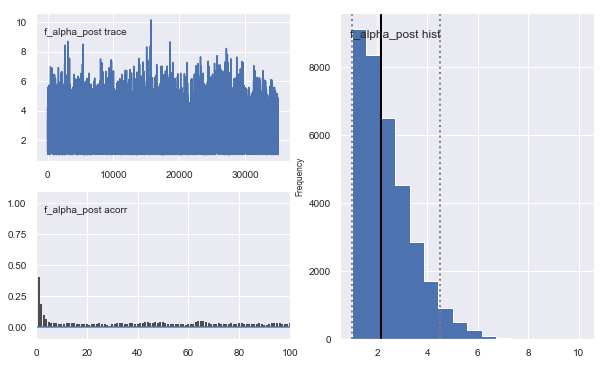

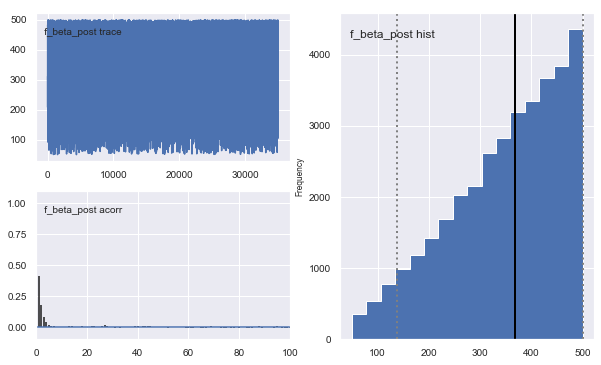

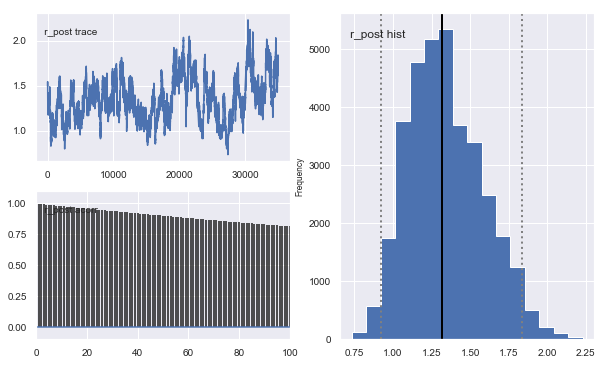

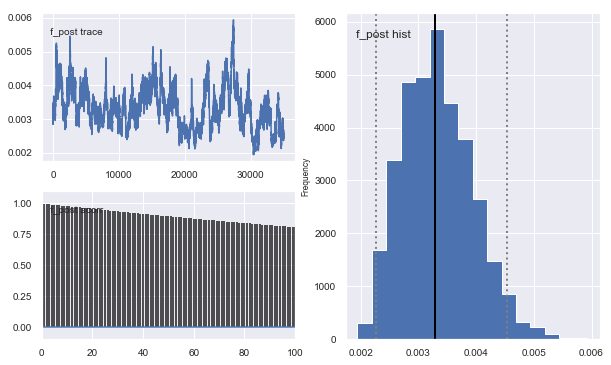

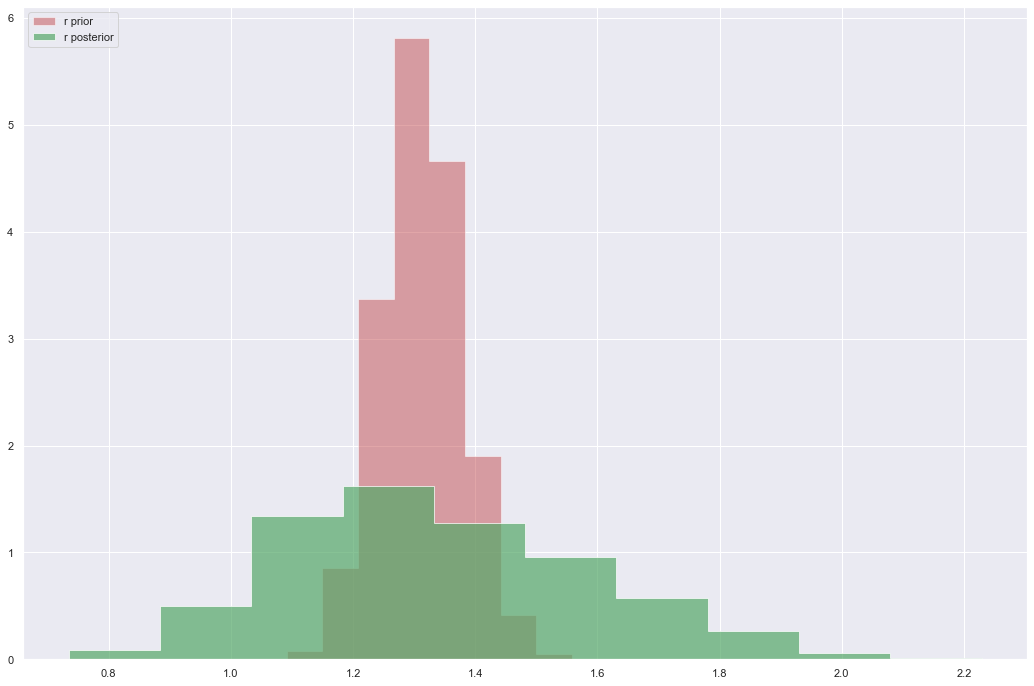

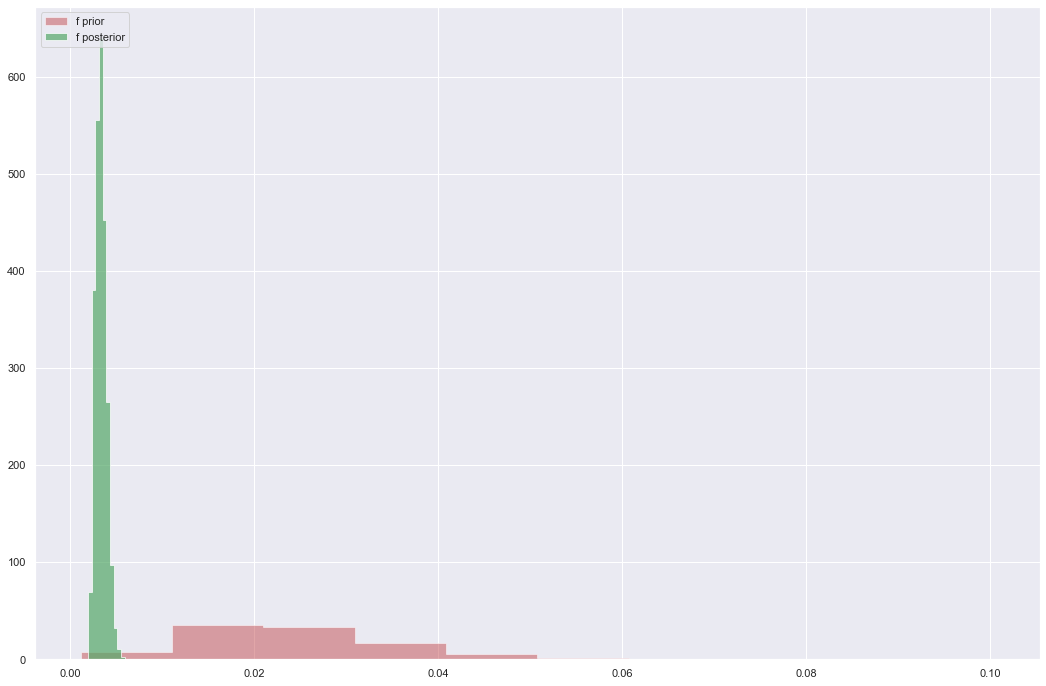

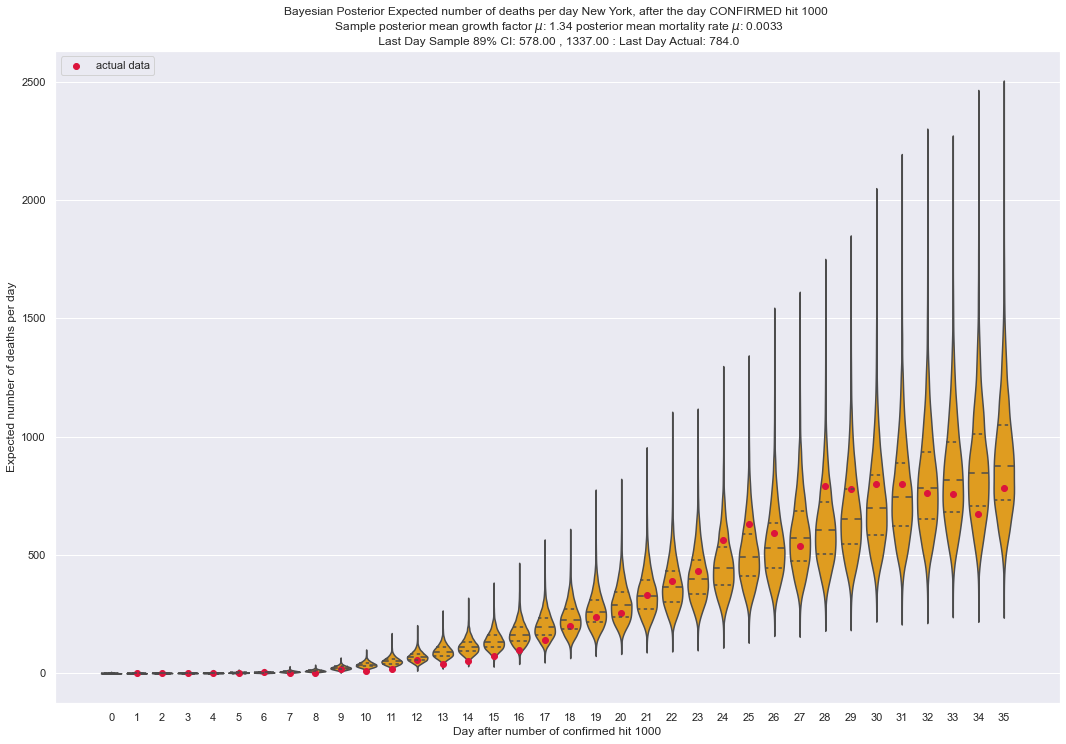

In [117]:
print (ny)

D = ny['dead_inc']
C = ny['confirmed']

country_name='New York'
result = inference(ny,C,D,'New York')
result.to_pickle('violin_daily_result_{}.pkl'.format(country_name.replace(' ','_')))
sample_df = create_posterior_samples(result)
plot(result,ny,sample_df,'New York')